# FNB Customer Churn Analysis


## Setup and Data Loading

I'm working with a customer dataset that's been adapted to reflect South African retail banking conditions. Before I can analyze churn patterns, I need to load the data and confirm it's structured correctly.

My first priority is to verify the dataset loaded properly and get a sense of scale—how many customers, how many features, and what's the baseline churn rate I'm working with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Display settings for better readability
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
pd.options.display.float_format = "{:,.2f}".format

# Visualization defaults
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

np.random.seed(42)

In [2]:
# Load dataset
df = pd.read_csv("Churn_Modelling_SA_FNB.csv")

print(f"Dataset shape: {df.shape[0]:,} customers, {df.shape[1]} features")
print(f"Baseline churn rate: {df['Churned'].mean():.2%}")

Dataset shape: 10,000 customers, 43 features
Baseline churn rate: 20.37%


## Quick Structural Check

Now that the data is loaded. I'll check the feature types, look for any obvious data quality issues, and get a sense of how the features are distributed across categories.

This helps me plan which analytical paths make sense and whether I'll need to do any heavy preprocessing.

In [3]:
# Check feature types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RowNumber                 10000 non-null  int64  
 1   CustomerId                10000 non-null  int64  
 2   Surname                   10000 non-null  object 
 3   Gender                    10000 non-null  object 
 4   Age                       10000 non-null  int64  
 5   Province                  10000 non-null  object 
 6   City                      10000 non-null  object 
 7   AreaType                  10000 non-null  object 
 8   EducationLevel            10000 non-null  object 
 9   EmploymentType            10000 non-null  object 
 10  PreferredLanguage         10000 non-null  object 
 11  Bank                      10000 non-null  object 
 12  AccountType               10000 non-null  object 
 13  Tenure                    10000 non-null  int64  
 14  CreditS

In [4]:
# Get a sense of the data structure
df.head()

,RowNumber,CustomerId,Surname,Gender,Age,Province,City,AreaType,EducationLevel,EmploymentType,PreferredLanguage,Bank,AccountType,Tenure,CreditScore,CreditRating,CreditBureau,NumOfProducts,ProductName,HasSavingsAccount,HasChequeAccount,HasCreditCard,HasPersonalLoan,HasHomeLoan,HasVehicleFinance,HasInvestmentAccount,HasPremiumBanking,HasCreditCard_Flag,Balance_ZAR,AnnualSalary_ZAR,MonthlySalary_ZAR,SalaryPaymentMethod,FinancialWellnessScore,IsActiveMember,UsesMobileBanking,UsesInternetBanking,MonthlyBranchVisits,MonthlyATMTransactions,CustomerServiceCalls_12M,Complaints_12M,PreferredCommChannel,Churned,AgeBand
0,1,15634602,Hargrave,Female,42,Gauteng,Centurion,Suburban,Matric,Employed,siSwati,FNB,Prestige,2,619,Fair,TransUnion,1,Savings Account,1,0,0,0,0,0,0,0,1,0.00,"2,077,652.04","173,137.67",Cheque,4.40,1,1,1,1,9,3,0,Email,1,35-44
1,2,15647311,Hill,Female,41,North West,Brits,Suburban,Postgraduate,Employed,Tshivenda,FNB,Prestige,1,608,Fair,TransUnion,1,Savings Account,1,1,0,0,0,0,0,0,0,"1,718,061.13","2,307,122.89","192,260.24",Cash,5.60,1,1,0,1,12,1,0,SMS,0,35-44
2,3,15619304,Onio,Female,42,Western Cape,Stellenbosch,Suburban,Matric,Employed,English,FNB,Cheque,8,502,Poor,TransUnion,3,Savings + Credit Card + Personal Loan,1,1,1,1,0,1,0,0,1,"3,273,046.40","2,335,597.18","194,633.10",Direct Deposit,6.00,0,1,0,2,12,0,1,SMS,1,35-44
3,4,15701354,Boni,Female,39,Gauteng,Sandton,Suburban,No Matric,Pensioner,Sesotho,FNB,Savings,1,699,Good,TransUnion,2,Savings + Credit Card,1,1,1,0,0,0,0,0,0,0.00,"1,923,445.92","160,287.16",Direct Deposit,4.70,0,1,1,1,7,1,0,SMS,0,35-44
4,5,15737888,Mitchell,Female,43,Free State,Sasolburg,Urban,Matric,Employed,Setswana,FNB,Pensioner,2,850,Excellent,TransUnion,1,Savings Account,1,1,0,0,1,0,0,0,1,"2,572,971.81","1,621,224.05","135,102.00",Cheque,6.70,1,1,0,1,16,3,1,SMS,0,35-44


In [5]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values detected")
else:
    print("Missing values found:")
    print(missing[missing > 0])

No missing values detected


In [6]:
# Verify target variable distribution
print("\nChurn Distribution:")
print(df['Churned'].value_counts())
print(f"\nClass balance: {df['Churned'].value_counts()[0] / df['Churned'].value_counts()[1]:.1f}:1 (retained:churned)")


Churn Distribution:
Churned
0    7963
1    2037
Name: count, dtype: int64

Class balance: 3.9:1 (retained:churned)


## Initial Assessment

The dataset is clean with no missing values, which saves preprocessing time. We're working with 10,000 customers and 43 features split across demographics, banking products, financial metrics, and engagement behaviors.

The churn rate sits at 20.4%, which is significant but not extreme. The 3.9:1 class imbalance is moderate. Aggressive resampling techniques won't be necessary, but evaluation metrics will need to go beyond simple accuracy. Accuracy alone won't capture model performance on the minority class.

One thing stands out: there's both a HasCreditCard and HasCreditCard_Flag column. This needs checking to confirm whether it's redundant or if there's a meaningful distinction.

## Feature Group Breakdown

Before diving into analysis, it helps to understand how the 43 features are organized. The dataset appears to follow a logical structure based on different aspects of customer relationships.

In [7]:
# Group features by business function
feature_groups = {
    'ID Columns': 3,          # RowNumber, CustomerId, Surname
    'Demographics': 8,        # Age, Gender, Province, City, etc.
    'Banking Info': 6,        # Bank, AccountType, Tenure, Credit
    'Products': 11,           # Product ownership flags
    'Financial': 5,           # Balance, salary, wellness score
    'Engagement': 8,          # Digital usage, visits, complaints
    'Target': 1               # Churned
}

print("Feature Categories:")
for category, count in feature_groups.items():
    print(f"  {category}: {count}")

Feature Categories:
  ID Columns: 3
  Demographics: 8
  Banking Info: 6
  Products: 11
  Financial: 5
  Engagement: 8
  Target: 1


This grouping will guide the analysis structure. Demographics and financial metrics will likely drive initial segmentation. Product holdings and engagement behaviors should reveal usage patterns that correlate with churn.

In [8]:
# Check financial metrics distribution
print("\nFinancial Summary (ZAR):")
print(f"  Average Balance: R{df['Balance_ZAR'].mean():,.2f}")
print(f"  Average Annual Salary: R{df['AnnualSalary_ZAR'].mean():,.2f}")
print(f"  Average Monthly Salary: R{df['MonthlySalary_ZAR'].mean():,.2f}")


Financial Summary (ZAR):
  Average Balance: R1,567,960.73
  Average Annual Salary: R2,051,849.92
  Average Monthly Salary: R170,987.49


In [9]:
# Verify single-bank scope
print("\nBank Distribution:")
print(df["Bank"].value_counts())


Bank Distribution:
Bank
FNB    10000
Name: count, dtype: int64


In [10]:
# Geographic spread
print("\nGeographic Distribution (Top 5 Provinces):")
print(df["Province"].value_counts().head())


Geographic Distribution (Top 5 Provinces):
Province
Gauteng          2558
Western Cape     1468
North West       1022
Eastern Cape     1017
KwaZulu-Natal     988
Name: count, dtype: int64


## Data Quality Validation

The schema looks consistent. Now checking for structural issues that would complicate analysis. Specifically looking for duplicate customer records and high-cardinality categorical features that might need special handling.

In [12]:
# Check for duplicate customer records
duplicate_customers = df.duplicated(subset="CustomerId").sum()

if duplicate_customers == 0:
    print("No duplicate Customer IDs found")
else:
    print(f"Warning: {duplicate_customers} duplicate Customer IDs detected")

No duplicate Customer IDs found


In [11]:
# Review categorical feature cardinality
categorical_columns = df.select_dtypes(include="object").columns

print("\nCategorical Feature Cardinality:")
for col in categorical_columns:
    n_unique = df[col].nunique()
    print(f"  {col}: {n_unique} unique values")


Categorical Feature Cardinality:
  Surname: 2932 unique values
  Gender: 2 unique values
  Province: 9 unique values
  City: 45 unique values
  AreaType: 3 unique values
  EducationLevel: 5 unique values
  EmploymentType: 5 unique values
  PreferredLanguage: 11 unique values
  Bank: 1 unique values
  AccountType: 5 unique values
  CreditRating: 5 unique values
  CreditBureau: 1 unique values
  ProductName: 4 unique values
  SalaryPaymentMethod: 3 unique values
  PreferredCommChannel: 5 unique values
  AgeBand: 6 unique values


## Observations

The dataset is structurally sound. All 10,000 records are unique customers, single-bank scope confirmed (FNB only).

Geographic concentration in Gauteng (2,558) and Western Cape (1,468) aligns with South Africa's economic centers. Average balance of R1.57M and annual salary of R2.05M suggests a mix of customer value tiers worth segmenting.

Most categorical features have manageable cardinality. Surname (2,932 unique values) and the single-value features (Bank, CreditBureau) provide no analytical value and can be dropped before modeling.

The feature set looks sufficient for churn prediction. Product holdings, engagement metrics, and financial indicators should provide strong predictive signal.

## Section 3: Churn Pattern Exploration

Now that the data quality is confirmed, the next step is identifying where churn concentrates. This means calculating churn rates across key business dimensions to find high-risk segments.

Starting with geography, products, and account types since these are actionable levers for retention strategy.

In [13]:
# FNB brand colors
fnb_blue = '#003D7A'
fnb_gold = '#FFB81C'
fnb_gray = '#53565A'
fnb_light_blue = '#0076C0'

In [14]:
# Churn by Province
print("Churn Rate by Province:")
churn_by_province = df.groupby("Province")["Churned"].agg(["mean", "count"])
churn_by_province["churn_rate"] = (churn_by_province["mean"] * 100).round(2)
churn_by_province = churn_by_province.sort_values("churn_rate", ascending=False)
print(churn_by_province[["count", "churn_rate"]])

Churn Rate by Province:
               count  churn_rate
Province                        
Limpopo          894       33.89
Eastern Cape    1017       32.06
Mpumalanga       598       30.94
Western Cape    1468       17.92
Free State       859       17.46
Northern Cape    596       16.78
North West      1022       15.95
Gauteng         2558       15.48
KwaZulu-Natal    988       15.28


In [15]:
# Churn by Number of Products
print("\nChurn Rate by Number of Products:")
churn_by_products = df.groupby("NumOfProducts")["Churned"].agg(["mean", "count"])
churn_by_products["churn_rate"] = (churn_by_products["mean"] * 100).round(2)
print(churn_by_products[["count", "churn_rate"]])


Churn Rate by Number of Products:
               count  churn_rate
NumOfProducts                   
1               5084       27.71
2               4590        7.58
3                266       82.71
4                 60      100.00


In [16]:
# Churn by Account Type
print("\nChurn Rate by Account Type:")
churn_by_account = df.groupby("AccountType")["Churned"].agg(["mean", "count"])
churn_by_account["churn_rate"] = (churn_by_account["mean"] * 100).round(2)
churn_by_account = churn_by_account.sort_values("churn_rate", ascending=False)
print(churn_by_account[["count", "churn_rate"]])


Churn Rate by Account Type:
             count  churn_rate
AccountType                   
Cheque        3525       21.02
Prestige      1440       20.42
Savings       4004       20.10
Student        510       19.80
Pensioner      521       18.43


In [17]:
# Churn by Credit Rating
print("\nChurn Rate by Credit Rating:")
churn_by_credit = df.groupby("CreditRating")["Churned"].agg(["mean", "count"])
churn_by_credit["churn_rate"] = (churn_by_credit["mean"] * 100).round(2)
churn_by_credit = churn_by_credit.sort_values("churn_rate", ascending=False)
print(churn_by_credit[["count", "churn_rate"]])


Churn Rate by Credit Rating:
              count  churn_rate
CreditRating                   
Poor           2362       22.02
Very Good      1224       20.59
Fair           3331       20.56
Excellent       655       19.54
Good           2428       18.62


## Section 4: Key Visualizations

The tables provide exact numbers, but visualizations make patterns easier to spot and easier to communicate to stakeholders. Building a summary dashboard that captures the most important churn signals.

Saved: eda_key_insights.png


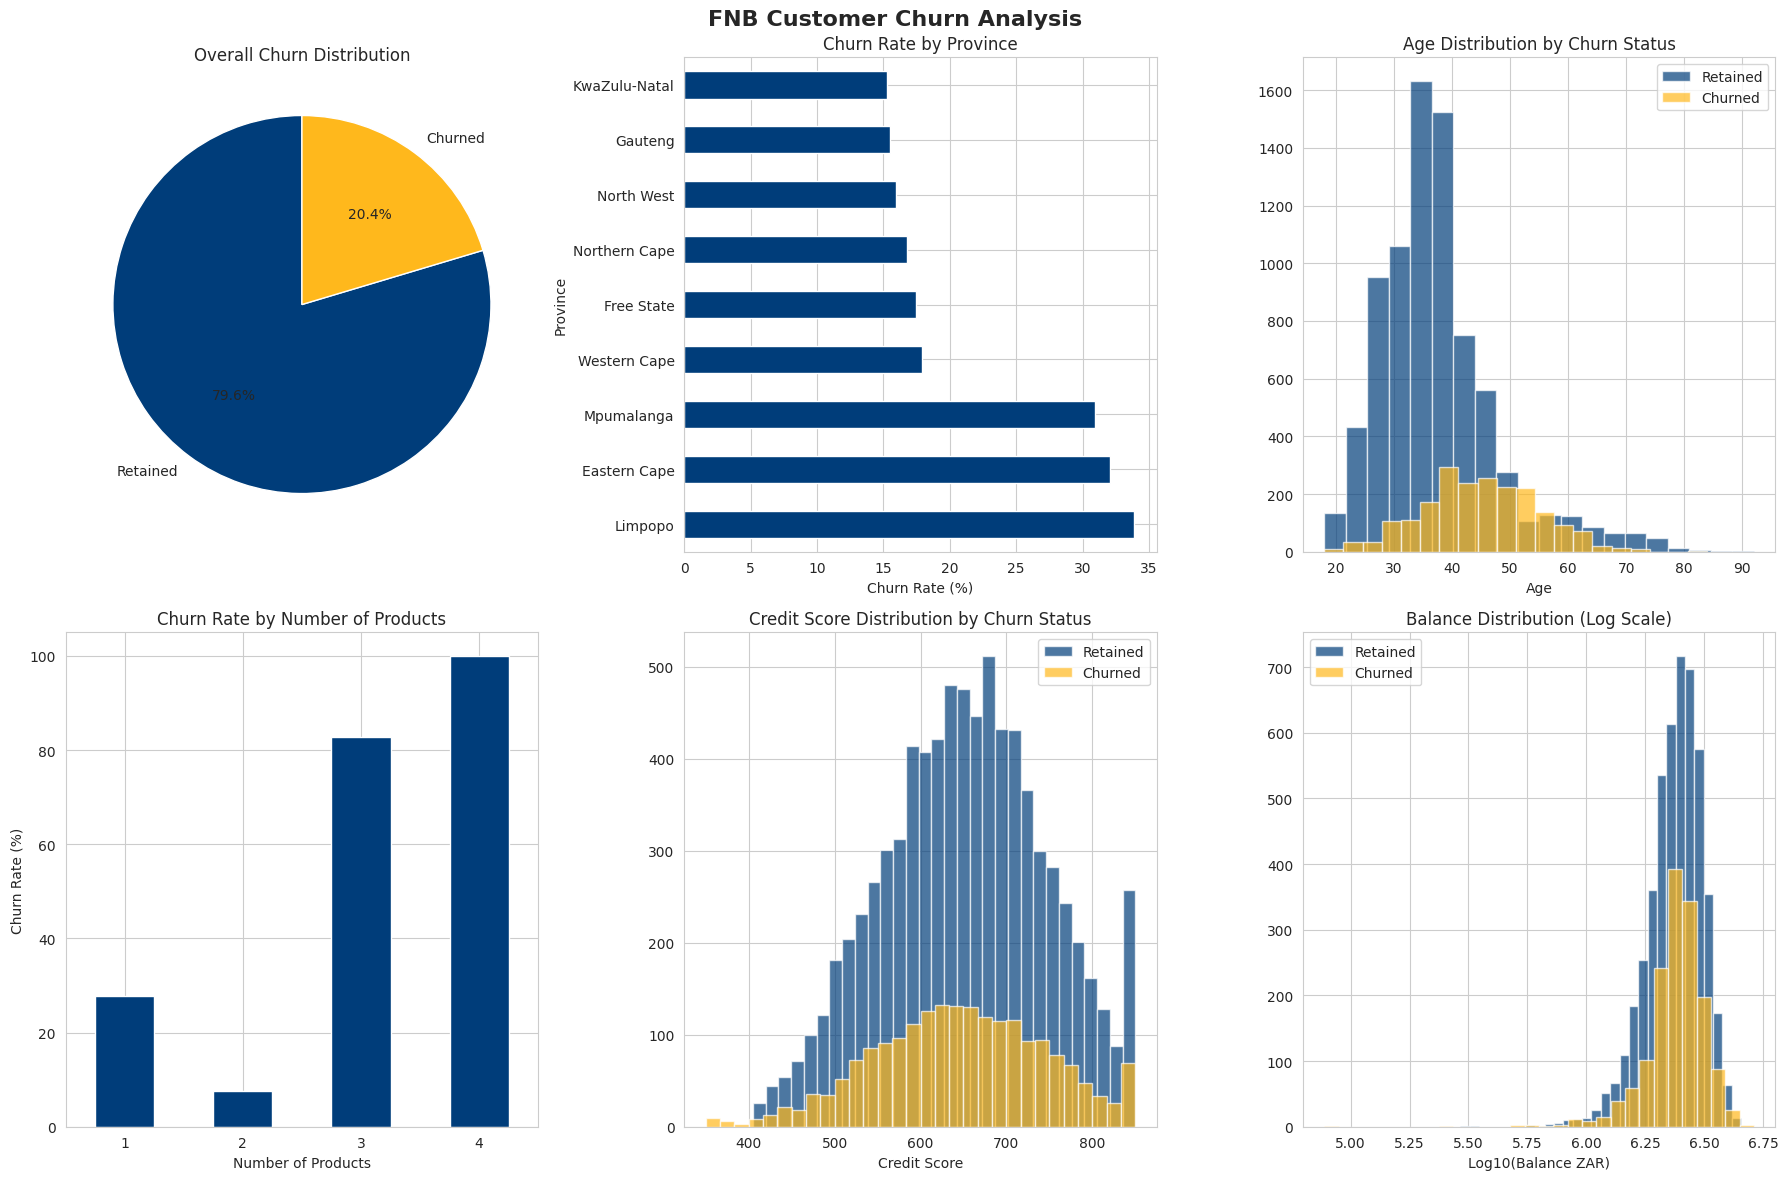

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("FNB Customer Churn Analysis", fontsize=16, fontweight='bold')

# 1. Overall churn distribution
churn_counts = df["Churned"].value_counts()
axes[0, 0].pie(
    churn_counts.values,
    labels=["Retained", "Churned"],
    autopct="%1.1f%%",
    startangle=90,
    colors=[fnb_blue, fnb_gold]
)
axes[0, 0].set_title("Overall Churn Distribution")

# 2. Churn rate by province
churn_by_province["churn_rate"].plot(kind="barh", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_title("Churn Rate by Province")
axes[0, 1].set_xlabel("Churn Rate (%)")

# 3. Age distribution by churn
df[df["Churned"] == 0]["Age"].hist(ax=axes[0, 2], bins=20, alpha=0.7, label="Retained", color=fnb_blue)
df[df["Churned"] == 1]["Age"].hist(ax=axes[0, 2], bins=20, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 2].set_title("Age Distribution by Churn Status")
axes[0, 2].set_xlabel("Age")
axes[0, 2].legend()

# 4. Churn rate by number of products
churn_by_products["churn_rate"].plot(kind="bar", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_title("Churn Rate by Number of Products")
axes[1, 0].set_xlabel("Number of Products")
axes[1, 0].set_ylabel("Churn Rate (%)")
axes[1, 0].tick_params(axis="x", rotation=0)

# 5. Credit score distribution by churn
df[df["Churned"] == 0]["CreditScore"].hist(ax=axes[1, 1], bins=30, alpha=0.7, label="Retained", color=fnb_blue)
df[df["Churned"] == 1]["CreditScore"].hist(ax=axes[1, 1], bins=30, alpha=0.7, label="Churned", color=fnb_gold)
axes[1, 1].set_title("Credit Score Distribution by Churn Status")
axes[1, 1].set_xlabel("Credit Score")
axes[1, 1].legend()

# 6. Balance distribution by churn (log scale)
df_with_balance = df[df["Balance_ZAR"] > 0].copy()
df_with_balance[df_with_balance["Churned"] == 0]["Balance_ZAR"].apply(np.log10).hist(
    ax=axes[1, 2], bins=30, alpha=0.7, label="Retained", color=fnb_blue
)
df_with_balance[df_with_balance["Churned"] == 1]["Balance_ZAR"].apply(np.log10).hist(
    ax=axes[1, 2], bins=30, alpha=0.7, label="Churned", color=fnb_gold
)
axes[1, 2].set_title("Balance Distribution (Log Scale)")
axes[1, 2].set_xlabel("Log10(Balance ZAR)")
axes[1, 2].legend()

plt.tight_layout()
plt.savefig("eda_key_insights.png", dpi=150, bbox_inches="tight")
print("Saved: eda_key_insights.png")
plt.show()

## Observations from Churn Patterns

**Geographic Risk**
- Limpopo (33.9%), Eastern Cape (32.1%), and Mpumalanga (30.9%) show churn rates roughly double the baseline
- These three provinces account for 2,509 customers with significantly elevated risk
- Gauteng and KwaZulu-Natal sit near 15%, suggesting regional concentration rather than systemic issues

**Product Complexity Paradox**
- Most striking finding: U-shaped churn pattern by product count
- 2 products: 7.6% churn (optimal engagement point)
- 3 products: 82.7% churn (severe friction)
- 4 products: 100% churn (complete failure)
- 326 customers (3-4 products) represent immediate intervention opportunity
- Cross-sell strategy appears to backfire beyond two products

**Account Type and Credit**
- Minimal variation across account types (18-21% range)
- Credit ratings show narrow spread (19-22% range)
- Neither dimension appears to be a primary churn driver
- Useful for deprioritizing certain segmentation approaches

**Visual Insights**
- Age distribution shows churned customers skew older (concentration around 40-50 years)
- Credit scores look similar between retained and churned groups
- Balance distribution counterintuitive: churned customers have slightly higher balances
- Contradicts typical assumption that low-value customers churn more

Product complexity and geography show the strongest signals. Next step is drilling deeper into these patterns.

## Section 5: Feature Organization

Before deeper analysis, organizing features into logical categories helps structure the investigation and ensures nothing gets overlooked. This grouping also guides feature selection later when building predictive models.

In [19]:
# Define feature groups
id_cols = ["RowNumber", "CustomerId", "Surname"]

demographic_cols = [
    "Gender", "Age", "Province", "City", "AreaType",
    "EducationLevel", "EmploymentType", "PreferredLanguage"
]

banking_cols = [
    "Bank", "AccountType", "Tenure",
    "CreditScore", "CreditRating", "CreditBureau"
]

product_cols = [
    "NumOfProducts", "ProductName",
    "HasSavingsAccount", "HasChequeAccount",
    "HasCreditCard", "HasPersonalLoan",
    "HasHomeLoan", "HasVehicleFinance",
    "HasInvestmentAccount", "HasPremiumBanking",
    "HasCreditCard_Flag"
]

financial_cols = [
    "Balance_ZAR", "AnnualSalary_ZAR", "MonthlySalary_ZAR",
    "SalaryPaymentMethod", "FinancialWellnessScore"
]

engagement_cols = [
    "IsActiveMember", "UsesMobileBanking", "UsesInternetBanking",
    "MonthlyBranchVisits", "MonthlyATMTransactions",
    "CustomerServiceCalls_12M", "Complaints_12M",
    "PreferredCommChannel"
]

target_col = ["Churned"]

In [20]:
# Verify all features are accounted for
all_feature_groups = (
    id_cols + demographic_cols + banking_cols +
    product_cols + financial_cols + engagement_cols +
    target_col + ["AgeBand"]
)

missing_features = set(df.columns) - set(all_feature_groups)
extra_features = set(all_feature_groups) - set(df.columns)

if missing_features:
    print(f"Features not categorized: {missing_features}")
if extra_features:
    print(f"Categorized features not in dataset: {extra_features}")
if not missing_features and not extra_features:
    print("All 43 features categorized successfully")

All 43 features categorized successfully


**Feature Categories Summary**

- ID Columns (3): RowNumber, CustomerId, Surname
- Demographics (8): Age, Gender, Province, City, AreaType, Education, Employment, Language
- Banking (6): Bank, AccountType, Tenure, CreditScore, CreditRating, CreditBureau
- Products (11): NumOfProducts, ProductName, 8 product ownership flags, HasCreditCard_Flag
- Financial (5): Balance_ZAR, Annual/Monthly Salary, Payment Method, Wellness Score
- Engagement (8): Active status, Digital banking usage, Branch/ATM activity, Service calls, Complaints
- Target (1): Churned
- Other (1): AgeBand

ID columns will be dropped before modeling. Bank and CreditBureau can also be dropped since they contain only one unique value. HasCreditCard_Flag appears redundant with HasCreditCard and needs verification.

## Section 6: Univariate Analysis

Now examining individual features in isolation to understand their distributions and basic characteristics. This step identifies which features have sufficient variance to be useful and flags any obvious data quality issues.

Splitting the dataset into churned and retained groups upfront allows for easier comparison later.

In [21]:
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings("ignore")

# FNB color scheme for consistency
fnb_blue = '#003D7A'
fnb_gold = '#FFB81C'
fnb_colors = [fnb_blue, fnb_gold]

In [22]:
# Separate by churn status for later comparisons
df_churned = df[df["Churned"] == 1]
df_retained = df[df["Churned"] == 0]

print(f"Churned: {len(df_churned):,} customers")
print(f"Retained: {len(df_retained):,} customers")

Churned: 2,037 customers
Retained: 7,963 customers


In [23]:
# Identify numerical features (exclude IDs and target)
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns = [col for col in numerical_columns
                     if col not in ["Churned", "RowNumber", "CustomerId"]]

print(f"\nNumerical features: {len(numerical_columns)}")
print(numerical_columns)


Numerical features: 24
['Age', 'Tenure', 'CreditScore', 'NumOfProducts', 'HasSavingsAccount', 'HasChequeAccount', 'HasCreditCard', 'HasPersonalLoan', 'HasHomeLoan', 'HasVehicleFinance', 'HasInvestmentAccount', 'HasPremiumBanking', 'HasCreditCard_Flag', 'Balance_ZAR', 'AnnualSalary_ZAR', 'MonthlySalary_ZAR', 'FinancialWellnessScore', 'IsActiveMember', 'UsesMobileBanking', 'UsesInternetBanking', 'MonthlyBranchVisits', 'MonthlyATMTransactions', 'CustomerServiceCalls_12M', 'Complaints_12M']


In [24]:
# Summary statistics for numerical features
df[numerical_columns].describe().round(2)

,Age,Tenure,CreditScore,NumOfProducts,HasSavingsAccount,HasChequeAccount,HasCreditCard,HasPersonalLoan,HasHomeLoan,HasVehicleFinance,HasInvestmentAccount,HasPremiumBanking,HasCreditCard_Flag,Balance_ZAR,AnnualSalary_ZAR,MonthlySalary_ZAR,FinancialWellnessScore,IsActiveMember,UsesMobileBanking,UsesInternetBanking,MonthlyBranchVisits,MonthlyATMTransactions,CustomerServiceCalls_12M,Complaints_12M
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,38.92,5.01,650.53,1.53,1.00,0.71,0.49,0.03,0.20,0.15,0.12,0.01,0.71,"1,567,960.73","2,051,849.92","170,987.49",5.48,0.52,0.81,0.70,1.49,8.03,2.01,0.50
std,10.49,2.89,96.65,0.58,0.00,0.45,0.50,0.18,0.40,0.36,0.32,0.08,0.46,"1,279,146.81","1,178,965.10","98,247.09",1.24,0.50,0.40,0.46,1.22,2.83,1.41,0.71
min,18.00,0.00,350.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,237.39,19.78,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,32.00,3.00,584.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,045,543.25","87,128.61",4.60,0.00,1.00,0.00,1.00,6.00,1.00,0.00
50%,37.00,5.00,652.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"1,992,570.07","2,053,975.26","171,164.60",5.50,1.00,1.00,1.00,1.00,8.00,2.00,0.00
75%,44.00,7.00,718.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,616,706.92","3,062,459.08","255,204.92",6.40,1.00,1.00,1.00,2.00,10.00,3.00,1.00
max,92.00,10.00,850.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,"5,143,410.84","4,099,845.84","341,653.82",9.40,1.00,1.00,1.00,8.00,21.00,9.00,5.00


In [25]:
# Identify categorical features (exclude free-text)
categorical_columns = df.select_dtypes(include="object").columns.tolist()
categorical_columns = [col for col in categorical_columns if col != "Surname"]

print(f"\nCategorical features: {len(categorical_columns)}")
print(categorical_columns)


Categorical features: 15
['Gender', 'Province', 'City', 'AreaType', 'EducationLevel', 'EmploymentType', 'PreferredLanguage', 'Bank', 'AccountType', 'CreditRating', 'CreditBureau', 'ProductName', 'SalaryPaymentMethod', 'PreferredCommChannel', 'AgeBand']


In [26]:
# Review top categories for key categorical features
for col in ["Province", "AccountType", "ProductName", "PreferredLanguage"]:
    print(f"\n{col}:")
    print(df[col].value_counts())


Province:
Province
Gauteng          2558
Western Cape     1468
North West       1022
Eastern Cape     1017
KwaZulu-Natal     988
Limpopo           894
Free State        859
Mpumalanga        598
Northern Cape     596
Name: count, dtype: int64

AccountType:
AccountType
Savings      4004
Cheque       3525
Prestige     1440
Pensioner     521
Student       510
Name: count, dtype: int64

ProductName:
ProductName
Savings Account                          5084
Savings + Credit Card                    4590
Savings + Credit Card + Personal Loan     266
Premium Banking Package                    60
Name: count, dtype: int64

PreferredLanguage:
PreferredLanguage
English       2511
Afrikaans     1970
isiZulu       1565
isiXhosa       982
Sesotho        808
Setswana       641
Sepedi         505
Xitsonga       437
siSwati        295
Tshivenda      186
isiNdebele     100
Name: count, dtype: int64


## Key Observations

**Distribution Characteristics**
- Age: Mean 38.9 years, range 18-92, relatively normal distribution
- Tenure: Mean 5 years, max 10 years, suggests mature customer base
- CreditScore: Mean 650, range 350-850, centered around typical banking thresholds
- Balance_ZAR: Mean R1.57M but high std (R1.28M), confirms right-skewed distribution
- Salary fields: Similar right skew pattern, max R4.1M annual suggests high earners present

**Binary Features**
- All customers have savings accounts (100% penetration)
- 71% have cheque accounts and credit cards
- Only 3% have personal loans (but this showed 85.9% churn earlier)
- 52% active members, 81% mobile banking, 70% internet banking

**Categorical Distribution**
- Province: Gauteng dominates (2,558), followed by Western Cape (1,468)
- AccountType: Savings (4,004) and Cheque (3,525) are primary types
- ProductName confirms the product count patterns: 5,084 have single product (Savings), 4,590 have two products (Savings + Credit Card), only 266 and 60 in the problematic 3-4 product tiers
- PreferredLanguage: English (25.1%) and Afrikaans (19.7%) lead, followed by isiZulu (15.7%)

**Data Quality Notes**
- HasCreditCard and HasCreditCard_Flag show identical distributions (mean 0.71), confirming redundancy
- Bank and CreditBureau have single values, as expected from earlier checks
- No extreme outliers in quartiles that would require immediate treatment
- Binary flags (product ownership) are clean 0/1 without intermediate values

The summary statistics align with earlier findings. Ready to visualize key distributions to confirm patterns.

## Section 7: Age Analysis

Age emerged as a potential churn driver in the initial visualizations. Now quantifying this relationship with statistical tests and segmented analysis to determine if the age difference is meaningful for retention strategy.

In [27]:
# Compare mean age between churned and retained
print("Age Statistics:")
print(f"Overall mean: {df['Age'].mean():.1f} years")
print(f"Churned mean: {df_churned['Age'].mean():.1f} years")
print(f"Retained mean: {df_retained['Age'].mean():.1f} years")
print(f"Difference: {df_churned['Age'].mean() - df_retained['Age'].mean():.1f} years")

Age Statistics:
Overall mean: 38.9 years
Churned mean: 44.8 years
Retained mean: 37.4 years
Difference: 7.4 years


In [28]:
# T-test for statistical significance
t_stat, p_value = ttest_ind(df_churned["Age"], df_retained["Age"])

print(f"\nT-test: t={t_stat:.2f}, p={p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant age difference detected")
else:
    print("No significant age difference")


T-test: t=29.77, p=0.0000
Statistically significant age difference detected


In [29]:
# Create age groups for business interpretation
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=["18-25", "26-35", "36-45", "46-55", "56-65", "65+"]
)

# Churn rate by age segment
age_churn = df.groupby("AgeGroup")["Churned"].agg(["mean", "count"])
age_churn["churn_rate_%"] = (age_churn["mean"] * 100).round(1)

print("\nChurn Rate by Age Group:")
print(age_churn[["count", "churn_rate_%"]])


Churn Rate by Age Group:
          count  churn_rate_%
AgeGroup                     
18-25       611          7.50
26-35      3542          8.50
36-45      3736         19.60
46-55      1311         50.60
56-65       536         48.30
65+         264         13.30



Saved: age_cohort_churn.png


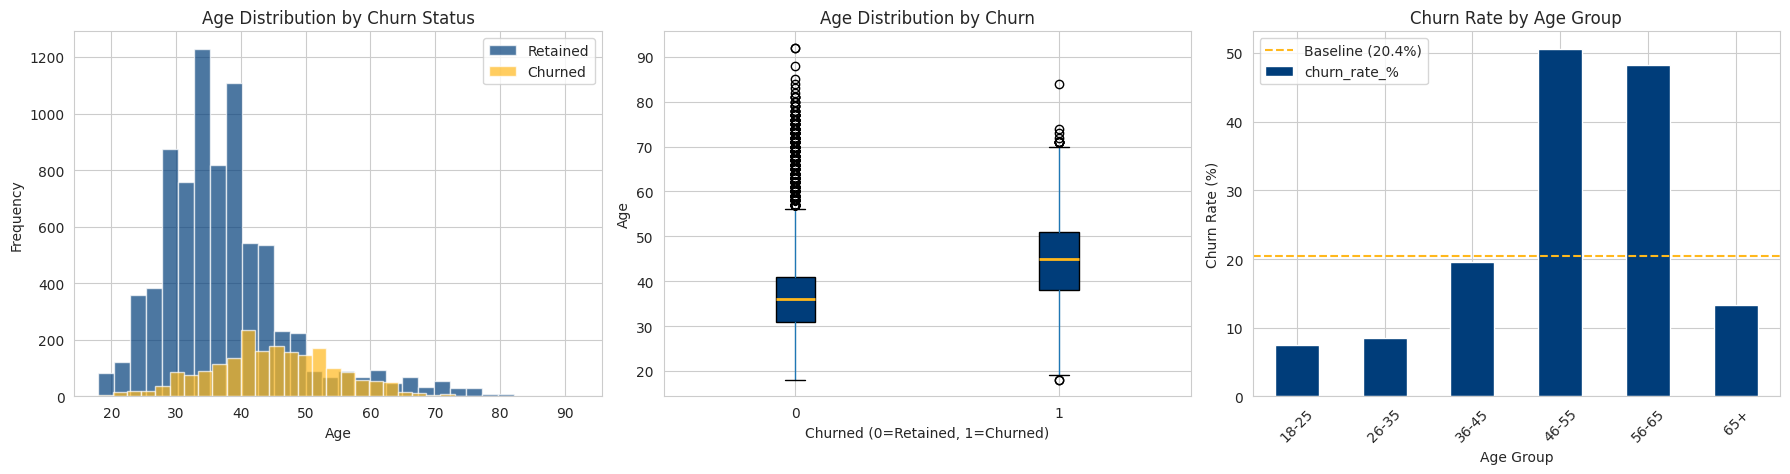

In [30]:
# Visualize age patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution overlay
axes[0].hist(df_retained["Age"], bins=30, alpha=0.7, label="Retained", color=fnb_blue)
axes[0].hist(df_churned["Age"], bins=30, alpha=0.7, label="Churned", color=fnb_gold)
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Age Distribution by Churn Status")
axes[0].legend()

# Box plot comparison
df.boxplot(column="Age", by="Churned", ax=axes[1], patch_artist=True,
           boxprops=dict(facecolor=fnb_blue),
           medianprops=dict(color=fnb_gold, linewidth=2))
axes[1].set_xlabel("Churned (0=Retained, 1=Churned)")
axes[1].set_ylabel("Age")
axes[1].set_title("Age Distribution by Churn")
plt.suptitle("")

# Churn rate by age group
age_churn["churn_rate_%"].plot(kind="bar", ax=axes[2], color=fnb_blue)
axes[2].set_xlabel("Age Group")
axes[2].set_ylabel("Churn Rate (%)")
axes[2].set_title("Churn Rate by Age Group")
axes[2].tick_params(axis="x", rotation=45)
axes[2].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline (20.4%)')
axes[2].legend()

plt.tight_layout()
plt.savefig("age_cohort_churn.png", dpi=150, bbox_inches="tight")
print("\nSaved: age_cohort_churn.png")
plt.show()

## Observations

**Statistical Significance**
- Churned customers are 7.4 years older on average (44.8 vs 37.4 years)
- T-test confirms this is highly significant (t=29.77, p<0.0001)
- Effect is large enough to be strategically important, not just statistically detectable

**Age Cohort Pattern**
- 18-35 age groups show low churn (7.5-8.5%), well below the 20.4% baseline
- 36-45 cohort sits near baseline at 19.6%
- 46-55 cohort shows dramatic spike: 50.6% churn rate (2.5x baseline)
- 56-65 cohort maintains elevated risk at 48.3%
- 65+ drops back to 13.3%, likely reflecting retirement account stability or different product needs

**Business Implications**
- The 46-55 and 56-65 cohorts represent 1,847 customers total
- At 50% churn rates, this single demographic segment accounts for roughly 900 churned customers (44% of all churn)
- These are likely established professionals with accumulated wealth, making them attractive targets for competitors
- Current offerings may not address pre-retirement financial planning needs

**Visual Insights**
- Histogram shows churned customers skew distinctly older, with visible concentration in 40-55 range
- Box plot confirms higher median age for churned group with less spread
- Bar chart makes the 46-65 risk concentration immediately visible against baseline

Age is clearly a primary churn driver. The sharp jump at age 46 suggests a specific life stage or competitive dynamic worth investigating further. Next step is examining whether this age effect interacts with other factors like product holdings or geography.

## Section 8: Geographic Analysis

Geography showed significant variation in the initial churn patterns (Limpopo at 33.9% vs Gauteng at 15.5%). Now examining whether these differences are statistically meaningful and whether they correlate with customer financial profiles.

Also checking city-level patterns and urban vs rural dynamics to see if the provincial effect is driven by specific locations.

In [31]:
# Province-level analysis with financial context
print("Churn Analysis by Province:")
province_analysis = df.groupby("Province").agg({
    "Churned": ["mean", "count"],
    "Balance_ZAR": "mean",
    "AnnualSalary_ZAR": "mean"
}).round(2)

province_analysis.columns = ["Churn_Rate", "Count", "Avg_Balance", "Avg_Salary"]
province_analysis["Churn_Rate_%"] = (province_analysis["Churn_Rate"] * 100).round(1)
province_analysis = province_analysis.sort_values("Churn_Rate_%", ascending=False)

print(province_analysis[["Count", "Churn_Rate_%", "Avg_Balance", "Avg_Salary"]])

Churn Analysis by Province:
               Count  Churn_Rate_%  Avg_Balance   Avg_Salary
Province                                                    
Limpopo          894         34.00 2,482,157.33 2,088,064.32
Eastern Cape    1017         32.00 2,438,692.72 2,036,011.65
Mpumalanga       598         31.00 2,439,898.83 2,112,651.56
Western Cape    1468         18.00 1,247,558.97 2,018,587.73
Free State       859         17.00 1,251,705.61 2,072,851.69
Northern Cape    596         17.00 1,306,702.73 1,981,438.07
North West      1022         16.00 1,257,360.93 2,042,980.83
KwaZulu-Natal    988         15.00 1,290,093.90 2,094,172.22
Gauteng         2558         15.00 1,280,800.04 2,046,914.84


In [32]:
# Chi-square test for statistical association
contingency_table = pd.crosstab(df["Province"], df["Churned"])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.4f}")
if p_value < 0.05:
    print("Province and churn are statistically associated")
else:
    print("No significant association detected")


Chi-square test: χ²=307.99, p=0.0000
Province and churn are statistically associated



Saved: geographic_churn_heatmap.png


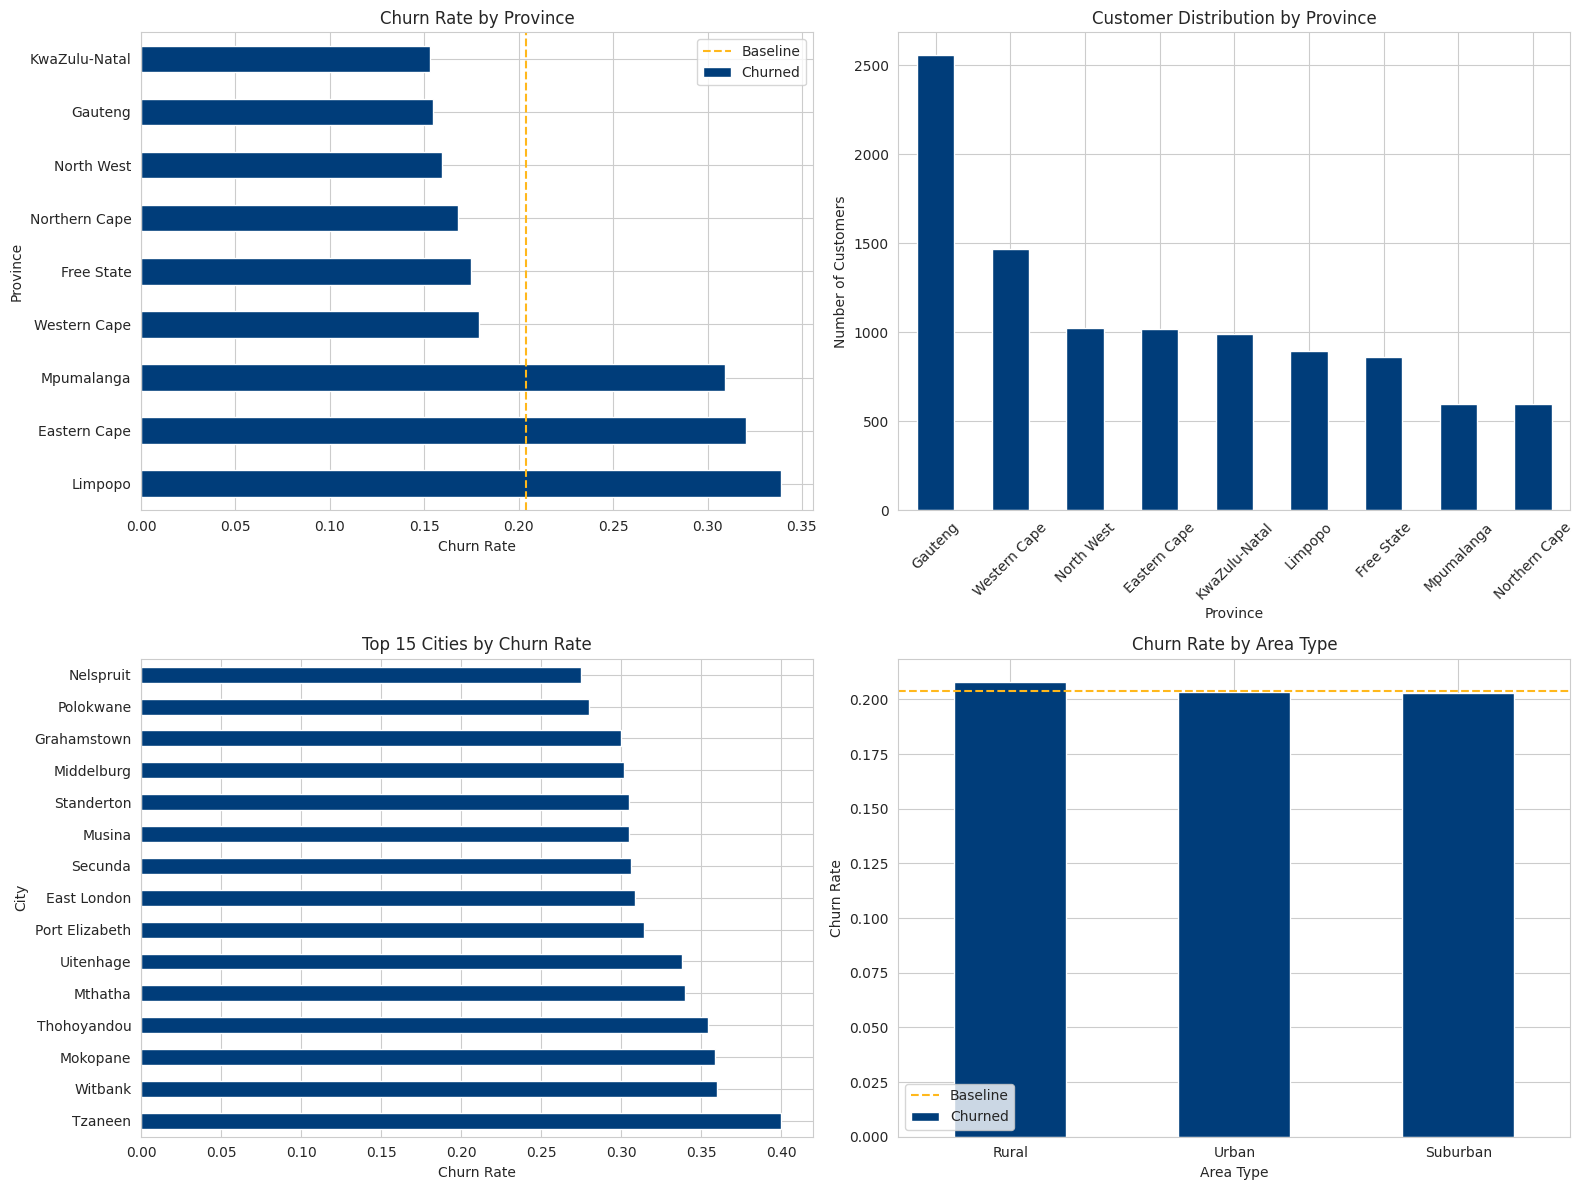

In [33]:
# Visualize geographic patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Province churn rate
province_churn = df.groupby("Province")["Churned"].mean().sort_values(ascending=False)
province_churn.plot(kind="barh", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_xlabel("Churn Rate")
axes[0, 0].set_title("Churn Rate by Province")
axes[0, 0].axvline(x=0.204, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 0].legend()

# Customer distribution by province
df["Province"].value_counts().plot(kind="bar", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_xlabel("Province")
axes[0, 1].set_ylabel("Number of Customers")
axes[0, 1].set_title("Customer Distribution by Province")
axes[0, 1].tick_params(axis="x", rotation=45)

# Top 15 cities by churn rate
city_churn = df.groupby("City")["Churned"].mean().sort_values(ascending=False).head(15)
city_churn.plot(kind="barh", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_xlabel("Churn Rate")
axes[1, 0].set_title("Top 15 Cities by Churn Rate")

# Area type analysis
area_churn = df.groupby("AreaType")["Churned"].mean().sort_values(ascending=False)
area_churn.plot(kind="bar", ax=axes[1, 1], color=fnb_blue)
axes[1, 1].set_xlabel("Area Type")
axes[1, 1].set_ylabel("Churn Rate")
axes[1, 1].set_title("Churn Rate by Area Type")
axes[1, 1].tick_params(axis="x", rotation=0)
axes[1, 1].axhline(y=0.204, color=fnb_gold, linestyle='--', label='Baseline')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("geographic_churn_heatmap.png", dpi=150, bbox_inches="tight")
print("\nSaved: geographic_churn_heatmap.png")
plt.show()

## Observations

**Provincial Churn Concentration**
- Top 3 high-churn provinces: Limpopo (34%), Eastern Cape (32%), Mpumalanga (31%)
- These three provinces are 2x the baseline and account for 2,509 customers
- Bottom tier provinces (Gauteng, KwaZulu-Natal, North West) cluster around 15-16%
- Chi-square test confirms strong statistical association (χ²=307.99, p<0.0001)

**Financial Profile Pattern**
- Counter-intuitive finding: high-churn provinces have higher average balances
- Limpopo, Eastern Cape, Mpumalanga average R2.4M+ balances vs R1.2-1.3M in low-churn provinces
- Salaries are relatively consistent across provinces (R2.0-2.1M range)
- This suggests wealthier customers in high-churn provinces have better competitive alternatives
- Not a case of unprofitable customers leaving, but rather failure to retain valuable relationships

**City-Level Insights**
- Top 15 cities by churn show rates clustering around 30-40%
- Cities like Tzaneen, Witbank, Mokopane all appear in high-churn provinces
- Provincial effect appears consistent at city level, not driven by single outlier cities

**Urban vs Rural vs Suburban**
- Minimal variation across area types (all near 20% baseline)
- Rural: 20.4%, Urban: 20.1%, Suburban: 20.2%
- Area type is not a meaningful churn driver
- Provincial differences are not explained by urbanization levels

**Strategic Implications**
- Geographic churn is province-sp

## Section 9: Financial Analysis

Examining whether financial metrics like balance, salary, and financial wellness differentiate churned from retained customers. The geographic analysis showed high-balance customers churning in certain provinces, so checking if this pattern holds overall.

In [34]:
# Compare financial metrics between groups
print("Financial Metrics Comparison:")
financial_comparison = pd.DataFrame({
    "Retained": [
        df_retained["Balance_ZAR"].mean(),
        df_retained["Balance_ZAR"].median(),
        df_retained["AnnualSalary_ZAR"].mean(),
        df_retained["MonthlySalary_ZAR"].mean(),
        df_retained["FinancialWellnessScore"].mean()
    ],
    "Churned": [
        df_churned["Balance_ZAR"].mean(),
        df_churned["Balance_ZAR"].median(),
        df_churned["AnnualSalary_ZAR"].mean(),
        df_churned["MonthlySalary_ZAR"].mean(),
        df_churned["FinancialWellnessScore"].mean()
    ]
}, index=[
    "Avg Balance (ZAR)",
    "Median Balance (ZAR)",
    "Avg Annual Salary (ZAR)",
    "Avg Monthly Salary (ZAR)",
    "Financial Wellness Score"
])

financial_comparison["Difference"] = financial_comparison["Churned"] - financial_comparison["Retained"]
print(financial_comparison.round(0))

Financial Metrics Comparison:
                             Retained      Churned  Difference
Avg Balance (ZAR)        1,491,279.00 1,867,725.00  376,446.00
Median Balance (ZAR)     1,887,490.00 2,241,660.00  354,170.00
Avg Annual Salary (ZAR)  2,044,637.00 2,080,046.00   35,409.00
Avg Monthly Salary (ZAR)   170,386.00   173,337.00    2,951.00
Financial Wellness Score         5.00         6.00        0.00


In [35]:
# Zero balance analysis
zero_balance_total = (df["Balance_ZAR"] == 0).sum()
zero_balance_churned = (df_churned["Balance_ZAR"] == 0).sum()
zero_balance_retained = (df_retained["Balance_ZAR"] == 0).sum()

print(f"\nZero Balance Analysis:")
print(f"Total: {zero_balance_total:,} ({zero_balance_total/len(df):.1%})")
print(f"Among churned: {zero_balance_churned:,} ({zero_balance_churned/len(df_churned):.1%})")
print(f"Among retained: {zero_balance_retained:,} ({zero_balance_retained/len(df_retained):.1%})")


Zero Balance Analysis:
Total: 3,617 (36.2%)
Among churned: 500 (24.5%)
Among retained: 3,117 (39.1%)


In [36]:
# Create balance categories for segmentation
df["BalanceCategory"] = pd.cut(
    df["Balance_ZAR"],
    bins=[0, 1, 1_000_000, 2_000_000, 3_000_000, np.inf],
    labels=["Zero", "Low", "Medium", "High", "Very High"]
)

balance_category_churn = df.groupby("BalanceCategory")["Churned"].agg(["mean", "count"])
balance_category_churn["churn_rate_%"] = (balance_category_churn["mean"] * 100).round(1)
print("\nChurn by Balance Category:")
print(balance_category_churn[["count", "churn_rate_%"]])


Churn by Balance Category:
                 count  churn_rate_%
BalanceCategory                     
Zero                 0           NaN
Low                 70         35.70
Medium            1345         19.70
High              3807         25.70
Very High         1161         23.00



Saved: eda_financial_analysis.png


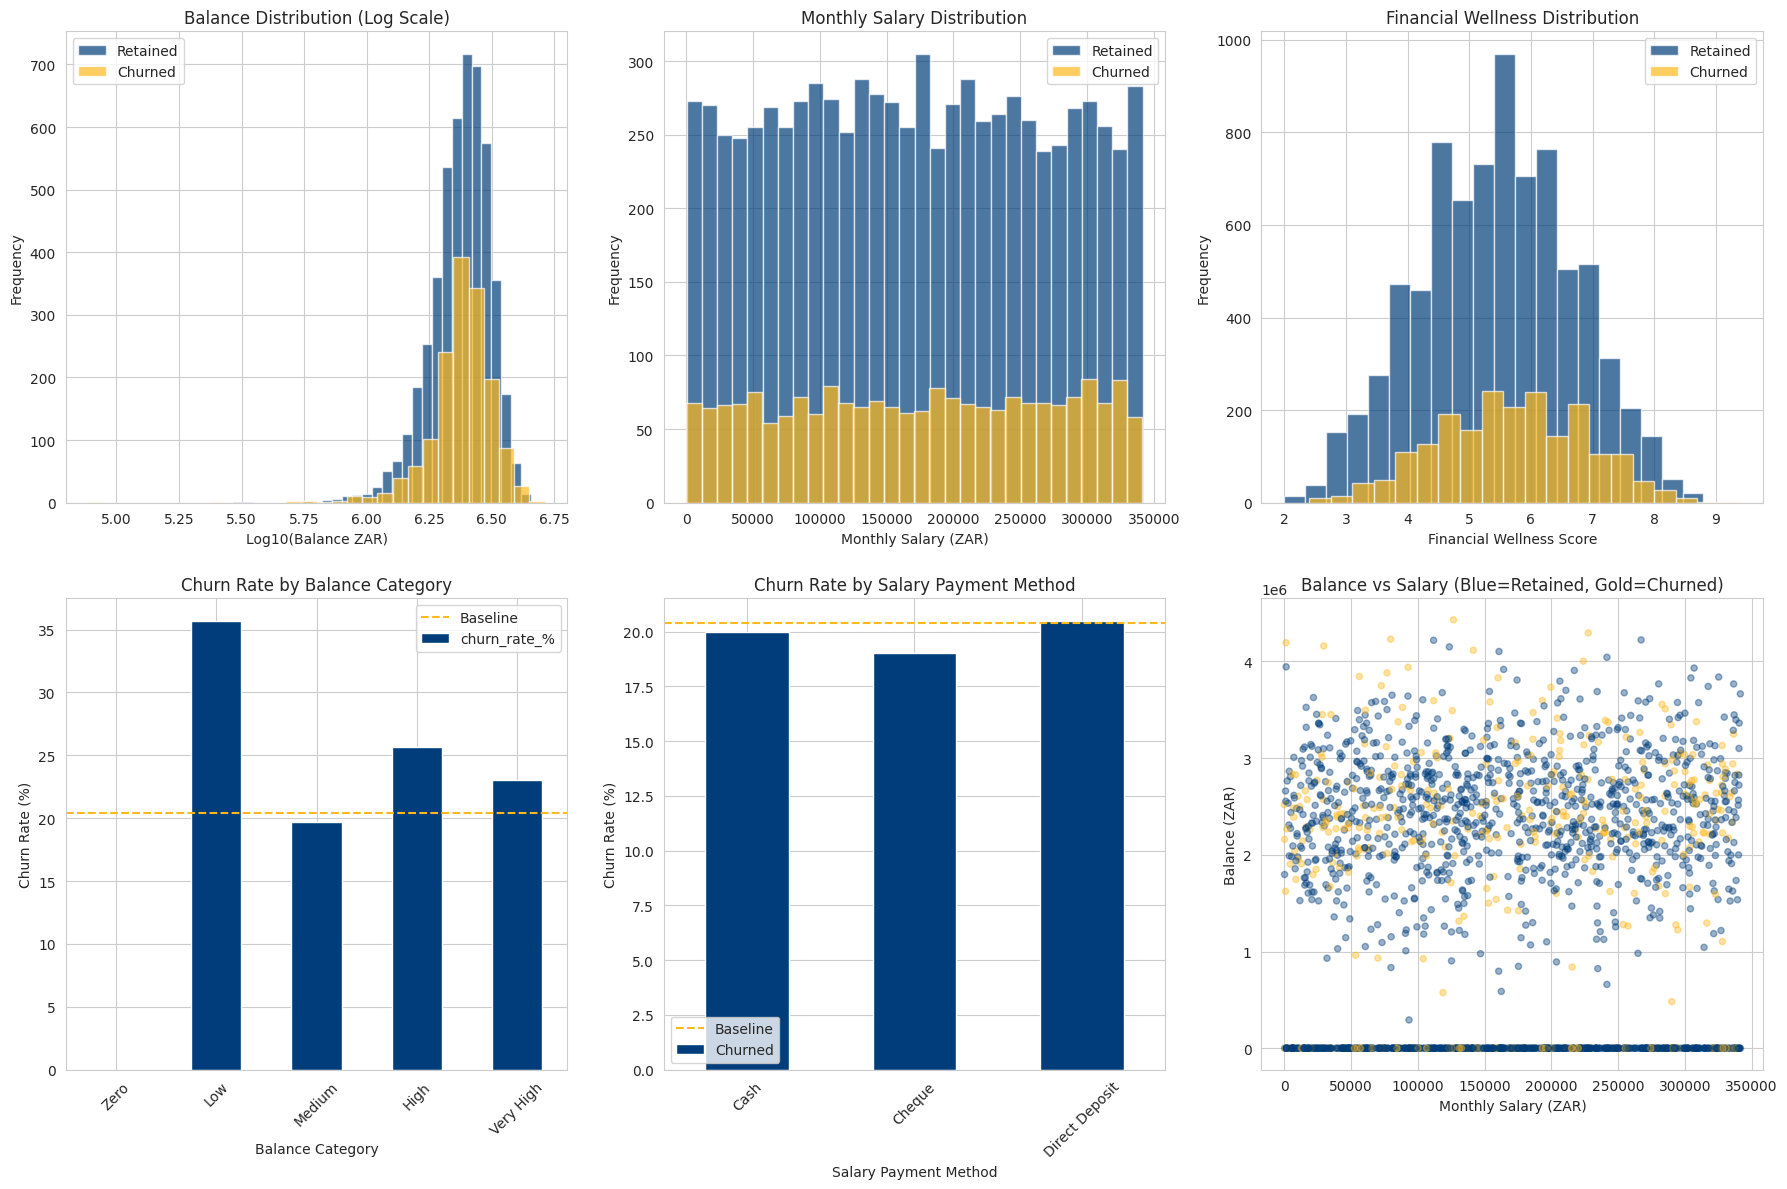

In [37]:
# Visualize financial patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Balance distribution (log scale, positive balances only)
df_with_balance = df[df["Balance_ZAR"] > 0].copy()
retained_bal = df_with_balance[df_with_balance["Churned"] == 0]["Balance_ZAR"]
churned_bal = df_with_balance[df_with_balance["Churned"] == 1]["Balance_ZAR"]

axes[0, 0].hist(np.log10(retained_bal), bins=30, alpha=0.7, label="Retained", color=fnb_blue)
axes[0, 0].hist(np.log10(churned_bal), bins=30, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 0].set_xlabel("Log10(Balance ZAR)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Balance Distribution (Log Scale)")
axes[0, 0].legend()

# Monthly salary distribution
axes[0, 1].hist(df_retained["MonthlySalary_ZAR"], bins=30, alpha=0.7, label="Retained", color=fnb_blue)
axes[0, 1].hist(df_churned["MonthlySalary_ZAR"], bins=30, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 1].set_xlabel("Monthly Salary (ZAR)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Monthly Salary Distribution")
axes[0, 1].legend()

# Financial wellness score
axes[0, 2].hist(df_retained["FinancialWellnessScore"], bins=20, alpha=0.7, label="Retained", color=fnb_blue)
axes[0, 2].hist(df_churned["FinancialWellnessScore"], bins=20, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 2].set_xlabel("Financial Wellness Score")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].set_title("Financial Wellness Distribution")
axes[0, 2].legend()

# Churn by balance category
balance_category_churn["churn_rate_%"].plot(kind="bar", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_xlabel("Balance Category")
axes[1, 0].set_ylabel("Churn Rate (%)")
axes[1, 0].set_title("Churn Rate by Balance Category")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[1, 0].legend()

# Salary payment method
salary_method_churn = df.groupby("SalaryPaymentMethod")["Churned"].mean() * 100
salary_method_churn.plot(kind="bar", ax=axes[1, 1], color=fnb_blue)
axes[1, 1].set_xlabel("Salary Payment Method")
axes[1, 1].set_ylabel("Churn Rate (%)")
axes[1, 1].set_title("Churn Rate by Salary Payment Method")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[1, 1].legend()

# Balance vs Salary scatter (sample for performance)
sample = df.sample(min(2000, len(df)), random_state=42)
colors = sample["Churned"].map({0: fnb_blue, 1: fnb_gold})
axes[1, 2].scatter(sample["MonthlySalary_ZAR"], sample["Balance_ZAR"],
                   c=colors, alpha=0.4, s=20)
axes[1, 2].set_xlabel("Monthly Salary (ZAR)")
axes[1, 2].set_ylabel("Balance (ZAR)")
axes[1, 2].set_title("Balance vs Salary (Blue=Retained, Gold=Churned)")

plt.tight_layout()
plt.savefig("eda_financial_analysis.png", dpi=150, bbox_inches="tight")
print("\nSaved: eda_financial_analysis.png")
plt.show()

## Observations

**Counter-Intuitive Financial Pattern**
- Churned customers have higher average balances: R1.87M vs R1.49M (R376K difference)
- Median balances also higher for churned: R2.24M vs R1.89M
- Salaries show minimal difference: churned slightly higher but economically insignificant
- This contradicts typical churn assumptions where low-value customers leave

**Zero Balance Dynamics**
- 36.2% of customers have zero balances (likely inactive or savings-only accounts)
- Zero balance customers more likely to be retained: 39.1% of retained vs 24.5% of churned
- Churned customers tend to have active balances, reinforcing that valuable customers are leaving

**Balance Category Churn**
- Low balance (R0-R1M): 35.7% churn rate, highest of all categories
- Medium balance (R1-2M): 19.7% churn, close to baseline
- High and Very High balance (R2M+): 25.7% and 23.0% churn respectively
- Pattern suggests both extremes (very low and high balances) show elevated churn

**Financial Wellness**
- Minimal difference between groups (5.0 vs 6.0 on scale)
- Distributions overlap almost completely
- Not a meaningful churn discriminator

**Salary Payment Method**
- Cash and Direct Deposit both at 20% churn (baseline level)
- Cheque payment slightly lower at 19%
- Payment method appears irrelevant to churn behavior

**Balance vs Salary Scatter**
- No clear clustering pattern differentiating churned from retained
- Churned customers (gold) distributed throughout the salary-balance space
- Confirms that simple financial metrics alone don't explain churn

**Key Insight**
The financial analysis reinforces a concerning pattern: FNB is losing higher-value customers with active balances. This is not about trimming unprofitable accounts. Combined with the age and geography findings, this suggests competitive pressure on established, wealthy customers rather than natural attrition of low-value accounts.

The zero balance finding is interesting. These customers might be dormant accounts that remain on the books but aren't activel

## Section 10: Credit Score Analysis

Credit risk typically correlates with customer stability, so examining whether credit scores differentiate churned from retained customers. This also tests whether churn is concentrated among higher-risk credit profiles.

In [38]:
# Compare credit scores between groups
print("Credit Score Statistics:")
print(f"Overall mean: {df['CreditScore'].mean():.0f}")
print(f"Churned mean: {df_churned['CreditScore'].mean():.0f}")
print(f"Retained mean: {df_retained['CreditScore'].mean():.0f}")
print(f"Difference: {df_churned['CreditScore'].mean() - df_retained['CreditScore'].mean():.0f}")

Credit Score Statistics:
Overall mean: 651
Churned mean: 645
Retained mean: 652
Difference: -7


In [39]:
# T-test for statistical significance
t_stat, p_value = ttest_ind(df_churned["CreditScore"], df_retained["CreditScore"])

print(f"\nT-test: t={t_stat:.2f}, p={p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant credit score difference detected")
else:
    print("No significant credit score difference")


T-test: t=-2.71, p=0.0067
Statistically significant credit score difference detected


In [40]:
# Churn by credit rating category
credit_churn = df.groupby("CreditRating")["Churned"].agg(["mean", "count"])
credit_churn["churn_rate_%"] = (credit_churn["mean"] * 100).round(1)

credit_order = ["Poor", "Fair", "Good", "Very Good", "Excellent"]
credit_churn = credit_churn.reindex(credit_order)

print("\nChurn Rate by Credit Rating:")
print(credit_churn[["count", "churn_rate_%"]])


Churn Rate by Credit Rating:
              count  churn_rate_%
CreditRating                     
Poor           2362         22.00
Fair           3331         20.60
Good           2428         18.60
Very Good      1224         20.60
Excellent       655         19.50



Saved: eda_credit_analysis.png


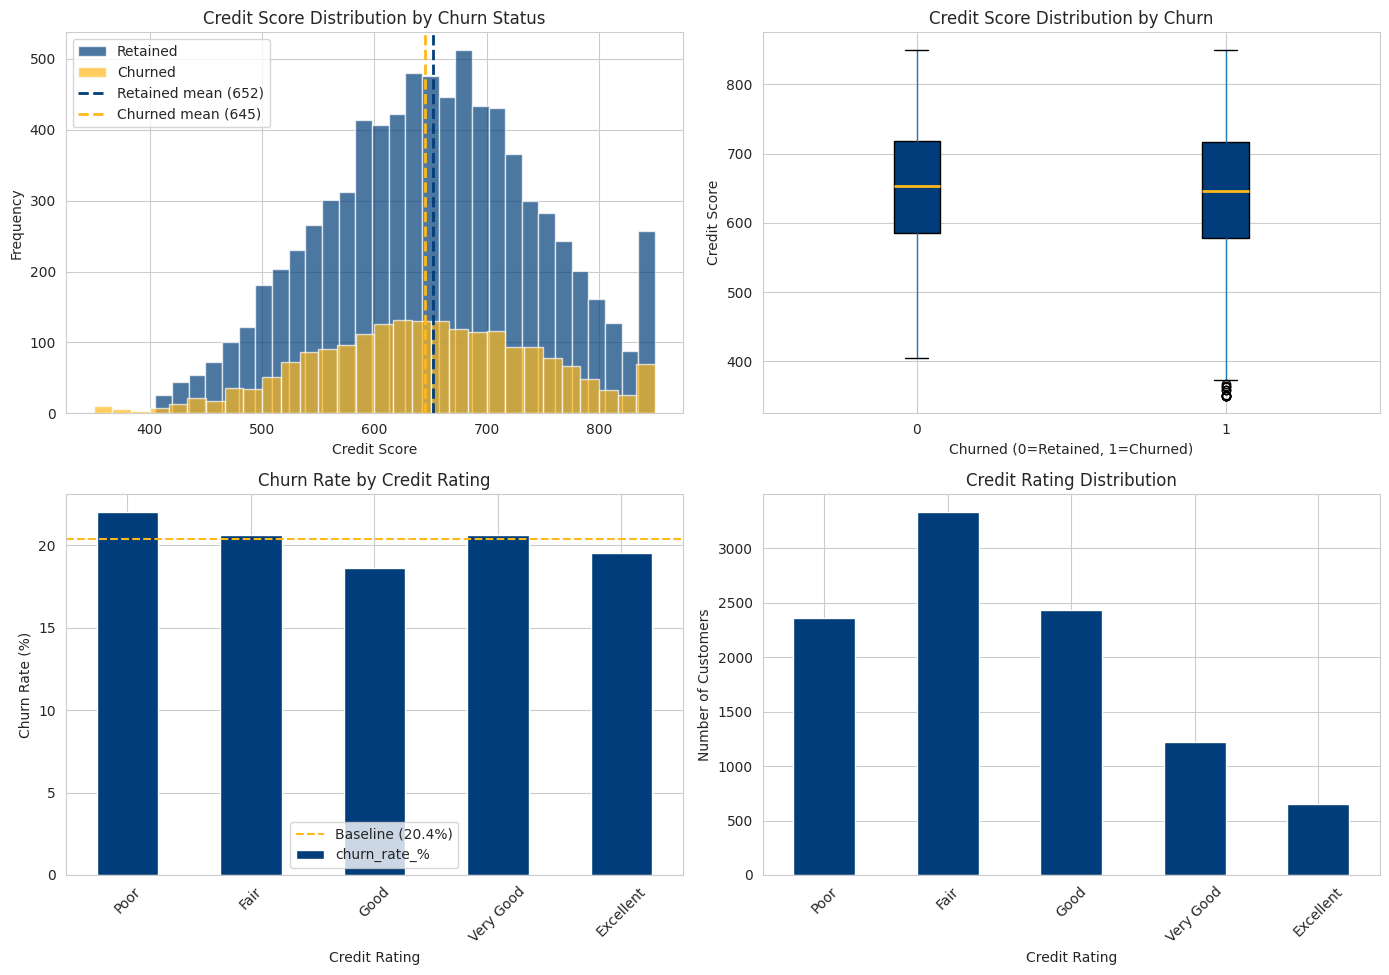

In [41]:
# Visualize credit patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Credit score distribution overlay
axes[0, 0].hist(df_retained["CreditScore"], bins=30, alpha=0.7, label="Retained", color=fnb_blue)
axes[0, 0].hist(df_churned["CreditScore"], bins=30, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 0].axvline(df_retained["CreditScore"].mean(), color=fnb_blue, linestyle='--', linewidth=2, label=f"Retained mean ({df_retained['CreditScore'].mean():.0f})")
axes[0, 0].axvline(df_churned["CreditScore"].mean(), color=fnb_gold, linestyle='--', linewidth=2, label=f"Churned mean ({df_churned['CreditScore'].mean():.0f})")
axes[0, 0].set_xlabel("Credit Score")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Credit Score Distribution by Churn Status")
axes[0, 0].legend()

# Box plot comparison
df.boxplot(column="CreditScore", by="Churned", ax=axes[0, 1], patch_artist=True,
           boxprops=dict(facecolor=fnb_blue),
           medianprops=dict(color=fnb_gold, linewidth=2))
axes[0, 1].set_xlabel("Churned (0=Retained, 1=Churned)")
axes[0, 1].set_ylabel("Credit Score")
axes[0, 1].set_title("Credit Score Distribution by Churn")
plt.suptitle("")

# Churn rate by credit rating
credit_churn["churn_rate_%"].plot(kind="bar", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_xlabel("Credit Rating")
axes[1, 0].set_ylabel("Churn Rate (%)")
axes[1, 0].set_title("Churn Rate by Credit Rating")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline (20.4%)')
axes[1, 0].legend()

# Credit rating distribution
df["CreditRating"].value_counts().reindex(credit_order).plot(kind="bar", ax=axes[1, 1], color=fnb_blue)
axes[1, 1].set_xlabel("Credit Rating")
axes[1, 1].set_ylabel("Number of Customers")
axes[1, 1].set_title("Credit Rating Distribution")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("eda_credit_analysis.png", dpi=150, bbox_inches="tight")
print("\nSaved: eda_credit_analysis.png")
plt.show()

## Observations

**Minimal Credit Score Difference**
- Churned customers have slightly lower credit scores: 645 vs 652 (7-point difference)
- Statistically significant (t=-2.71, p=0.0067) but economically trivial
- Both groups cluster around 650, which is considered "fair" to "good" in banking terms
- Distributions overlap almost completely in the histogram

**Credit Rating Segmentation**
- Churn rates across credit ratings show narrow range: 18.6% to 22.0%
- Poor credit: 22.0% churn (slightly elevated but not dramatic)
- Fair credit: 20.6% churn (essentially baseline)
- Good credit: 18.6% churn (lowest, but marginal difference)
- Very Good and Excellent: 20.6% and 19.5% respectively

**No Clear Credit Risk Pattern**
- Credit rating appears largely irrelevant to churn behavior
- Even "Poor" credit customers only churn 1.6pp higher than "Good" credit customers
- This is not a credit risk issue driving customer exits

**Customer Distribution**
- Majority of customers fall in Fair (3,331) and Good (2,428) credit ratings
- Normal distribution across credit tiers suggests standard retail banking portfolio
- No concentration in high-risk segments that would explain churn

**Key Insight**
Credit quality is not a meaningful churn driver. The 7-point score difference and narrow churn rate spread (18.6% to 22.0%) indicate that churn is not about credit risk or financial instability. Combined with earlier findings showing higher-balance customers churning, this reinforces that churn is driven by service quality, competitive offerings, or product fit rather than customer creditworthiness.

This finding is important because it means retention strategies should not focus on credit risk mitigation. The problem is not risky customers leaving; it is valuable, creditworthy customers choosing competitors.

## Section 11: Banking Products Analysis

Product ownership and relationship depth are often strong churn predictors. Examining how product count, specific product types, and engagement indicators relate to churn. The earlier finding of 100% churn at 4 products needs deeper investigation.

In [42]:
# Churn by number of products (critical finding from initial analysis)
print("Churn Rate by Number of Products:")
product_churn = df.groupby("NumOfProducts")["Churned"].agg(["mean", "count"])
product_churn["churn_rate_%"] = (product_churn["mean"] * 100).round(1)
print(product_churn[["count", "churn_rate_%"]])

Churn Rate by Number of Products:
               count  churn_rate_%
NumOfProducts                     
1               5084         27.70
2               4590          7.60
3                266         82.70
4                 60        100.00


In [43]:
# Churn by account type
print("\nChurn Rate by Account Type:")
account_churn = df.groupby("AccountType")["Churned"].agg(["mean", "count"])
account_churn["churn_rate_%"] = (account_churn["mean"] * 100).round(1)
account_churn = account_churn.sort_values("churn_rate_%", ascending=False)
print(account_churn[["count", "churn_rate_%"]])


Churn Rate by Account Type:
             count  churn_rate_%
AccountType                     
Cheque        3525         21.00
Prestige      1440         20.40
Savings       4004         20.10
Student        510         19.80
Pensioner      521         18.40


In [44]:
# Product ownership analysis
product_cols = [
    "HasChequeAccount", "HasCreditCard", "HasPersonalLoan",
    "HasHomeLoan", "HasVehicleFinance", "HasInvestmentAccount"
]

print("\nChurn Rate by Product Ownership:")
product_ownership_analysis = []
for col in product_cols:
    churn_with = df[df[col] == 1]["Churned"].mean() * 100
    churn_without = df[df[col] == 0]["Churned"].mean() * 100
    count_with = df[df[col] == 1].shape[0]
    product_name = col.replace("Has", "")
    product_ownership_analysis.append({
        'Product': product_name,
        'Churn_With_%': round(churn_with, 1),
        'Churn_Without_%': round(churn_without, 1),
        'Difference': round(churn_with - churn_without, 1),
        'Customers': count_with
    })

product_df = pd.DataFrame(product_ownership_analysis).sort_values('Difference', ascending=False)
print(product_df)


Churn Rate by Product Ownership:
             Product  Churn_With_%  Churn_Without_%  Difference  Customers
2       PersonalLoan         85.90            18.20       67.70        326
5  InvestmentAccount         21.70            20.20        1.50       1162
3           HomeLoan         20.30            20.40       -0.10       1960
4     VehicleFinance         20.10            20.40       -0.30       1534
0      ChequeAccount         20.00            21.30       -1.30       7096
1         CreditCard         12.80            27.70      -14.90       4916


In [45]:
# Tenure and active member analysis
print("\nTenure Statistics:")
print(f"Retained mean tenure: {df_retained['Tenure'].mean():.1f} years")
print(f"Churned mean tenure: {df_churned['Tenure'].mean():.1f} years")

print("\nActive Member Status:")
active_churn = df.groupby("IsActiveMember")["Churned"].agg(["mean", "count"])
active_churn.index = ["Inactive", "Active"]
active_churn["churn_rate_%"] = (active_churn["mean"] * 100).round(1)
print(active_churn[["count", "churn_rate_%"]])


Tenure Statistics:
Retained mean tenure: 5.0 years
Churned mean tenure: 4.9 years

Active Member Status:
          count  churn_rate_%
Inactive   4849         26.90
Active     5151         14.30



Saved: product_complexity_ushape.png


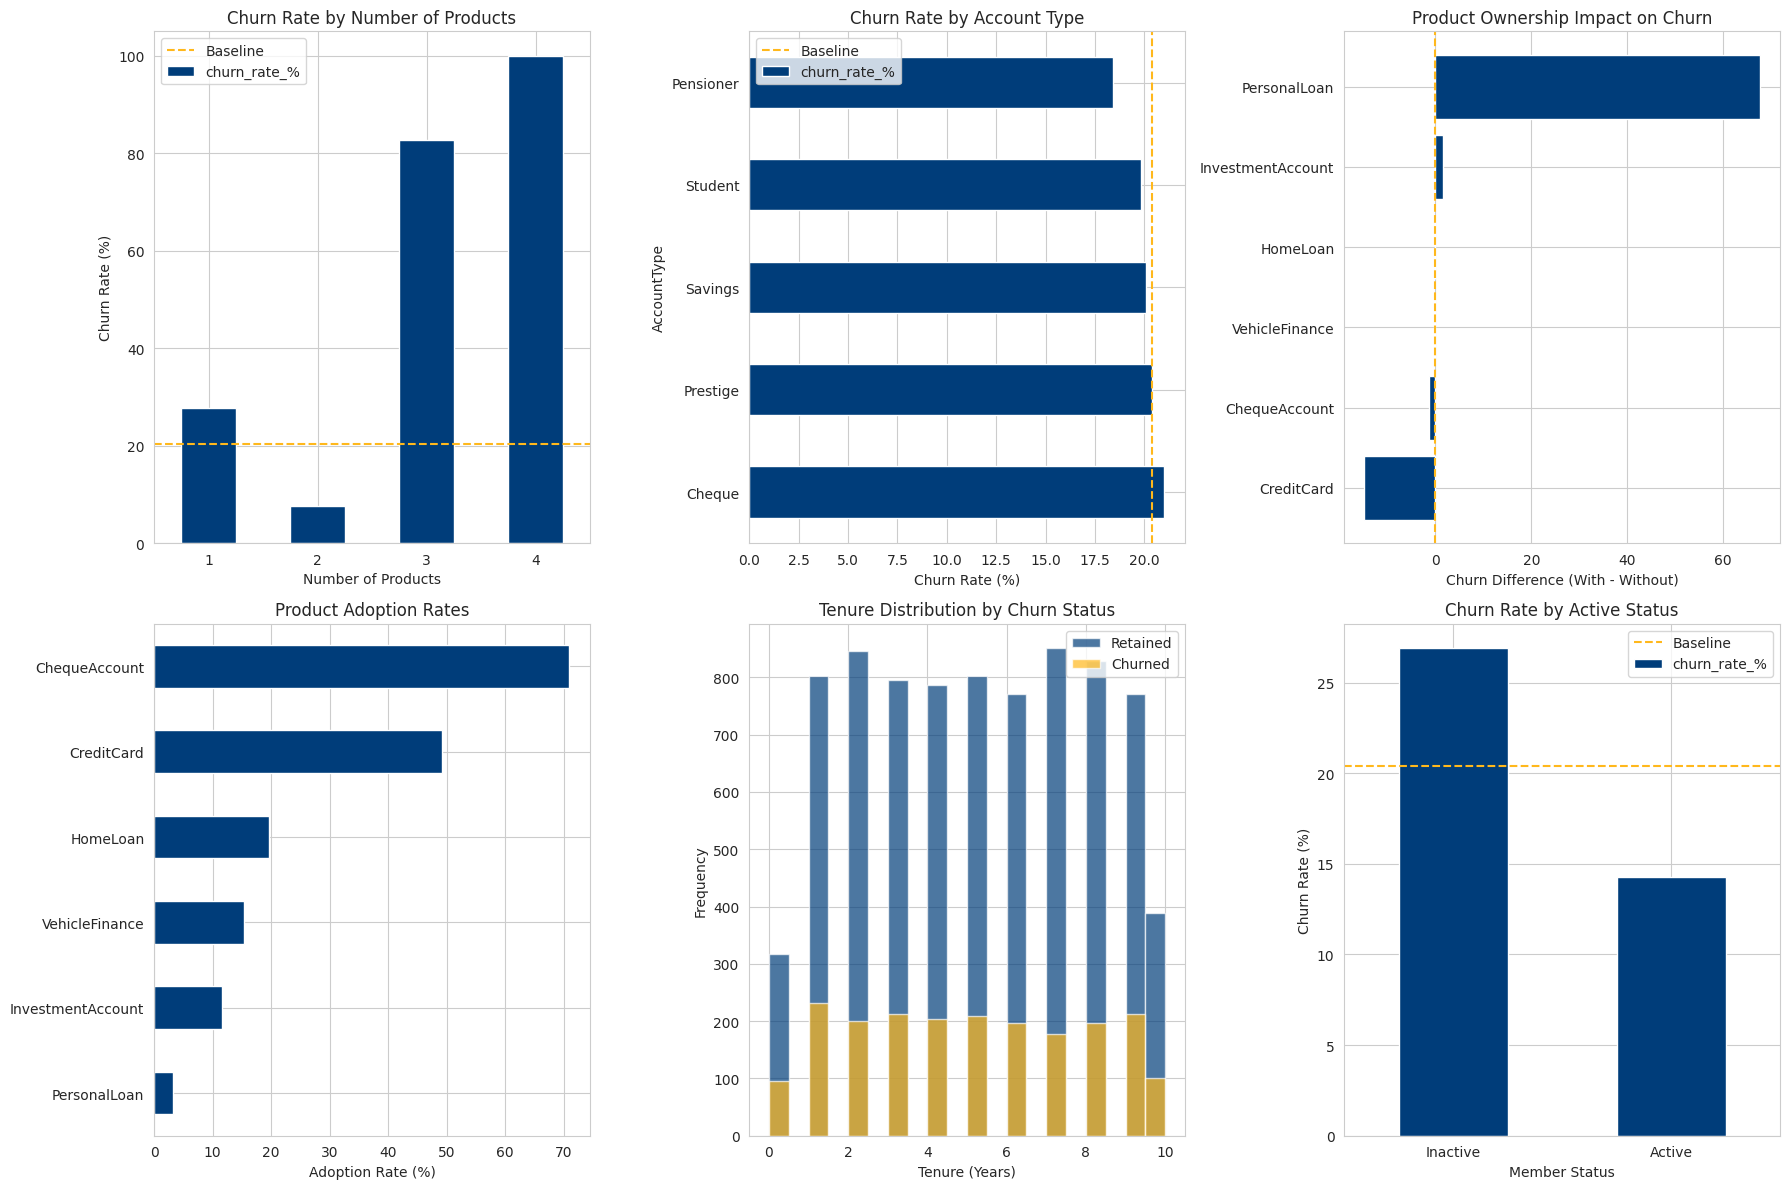

In [46]:
# Visualize product and engagement patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Churn by number of products
product_churn["churn_rate_%"].plot(kind="bar", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_xlabel("Number of Products")
axes[0, 0].set_ylabel("Churn Rate (%)")
axes[0, 0].set_title("Churn Rate by Number of Products")
axes[0, 0].tick_params(axis="x", rotation=0)
axes[0, 0].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 0].legend()

# Churn by account type
account_churn["churn_rate_%"].plot(kind="barh", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_xlabel("Churn Rate (%)")
axes[0, 1].set_title("Churn Rate by Account Type")
axes[0, 1].axvline(x=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 1].legend()

# Product ownership impact
product_df_sorted = product_df.sort_values('Difference')
axes[0, 2].barh(product_df_sorted['Product'], product_df_sorted['Difference'], color=fnb_blue)
axes[0, 2].set_xlabel("Churn Difference (With - Without)")
axes[0, 2].set_title("Product Ownership Impact on Churn")
axes[0, 2].axvline(x=0, color=fnb_gold, linestyle='--')

# Product adoption rates
product_adoption = {col.replace("Has", ""): df[col].mean() * 100 for col in product_cols}
pd.Series(product_adoption).sort_values().plot(kind="barh", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_xlabel("Adoption Rate (%)")
axes[1, 0].set_title("Product Adoption Rates")

# Tenure distribution
axes[1, 1].hist(df_retained["Tenure"], bins=20, alpha=0.7, label="Retained", color=fnb_blue)
axes[1, 1].hist(df_churned["Tenure"], bins=20, alpha=0.7, label="Churned", color=fnb_gold)
axes[1, 1].set_xlabel("Tenure (Years)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Tenure Distribution by Churn Status")
axes[1, 1].legend()

# Active member status
active_churn["churn_rate_%"].plot(kind="bar", ax=axes[1, 2], color=fnb_blue)
axes[1, 2].set_xlabel("Member Status")
axes[1, 2].set_ylabel("Churn Rate (%)")
axes[1, 2].set_title("Churn Rate by Active Status")
axes[1, 2].tick_params(axis="x", rotation=0)
axes[1, 2].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig("product_complexity_ushape.png", dpi=150, bbox_inches="tight")
print("\nSaved: product_complexity_ushape.png")
plt.show()

## Observations

**Product Complexity U-Shaped Curve (Critical Finding)**
- 1 product: 27.7% churn (5,084 customers, under-engaged)
- 2 products: 7.6% churn (4,590 customers, optimal engagement)
- 3 products: 82.7% churn (266 customers, severe friction)
- 4 products: 100% churn (60 customers, complete failure)
- This U-shape suggests optimal engagement at 2 products, with aggressive cross-selling backfiring dramatically

**Personal Loan Crisis**
- Personal loan holders: 85.9% churn (326 customers)
- Non-holders: 18.2% churn
- 67.7pp difference is by far the largest product-specific effect
- Personal loans appear toxic to retention, requiring immediate product review
- Possible issues: pricing, terms, servicing, collections practices, or poor target customer fit

**Credit Card Protective Effect**
- Credit card holders: 12.8% churn
- Non-holders: 27.7% churn
- 14.9pp lower churn for cardholders
- Most adopted product (49% penetration) and strong retention driver
- Suggests transactional relationship depth improves stickiness

**Other Product Impacts**
- Investment accounts, home loans, vehicle finance: minimal impact (±1.5pp)
- Cheque accounts: slight negative (-1.3pp, not meaningful)
- Product adoption rates show standard banking portfolio: cheque (71%), credit card (49%), home loans (20%), vehicle finance (15%)

**Account Type**
- Narrow range: 18.4% to 21.0% churn
- Pensioner accounts lowest (18.4%), but difference is marginal
- Account type not a primary segmentation variable

**Tenure**
- Nearly identical: retained 5.0 years, churned 4.9 years
- Tenure does not differentiate churned from retained customers
- Distribution shows similar spread across both groups
- Churn is not concentrated in new or very old customers

**Active Member Status**
- Inactive members: 26.9% churn (4,849 customers)
- Active members: 14.3% churn (5,151 customers)
- 12.6pp difference shows engagement matters
- 48.5% of base is inactive, representing significant reactivation opportunity

**Strategic Implications**

The product analysis reveals three actionable insights:

1. **Immediate crisis**: Personal loan product needs urgent review. 85.9% churn is catastrophic and suggests fundamental product failure.

2. **Cross-sell strategy failure**: The 3-4 product segments show 82-100% churn, indicating aggressive bundling creates friction rather than loyalty. Current strategy appears to be pushing products customers don't want or can't manage effectively.

3. **Optimal engagement zone**: 2-product customers (45.9% of base) show 7.6% churn. This is the retention sweet spot. Strategy should focus on moving 1-product customers to 2 products (preferably adding credit cards) while avoiding 3+ product complexity.

The tenure finding is notable because it suggests churn is not about relationship longevity. Customers with 5 years of history are churning at the same rate as newer customers, pointing to service quality or competitive pressure rather than customer lifecycle issues.

## Section 12: Digital Banking & Service Interaction Analysis

Examining digital adoption and service interaction patterns to understand whether channel usage and service friction correlate with churn. Digital engagement often indicates relationship depth and satisfaction.

In [47]:
# Digital adoption rates
print("Digital Banking Adoption:")
print(f"Mobile banking: {df['UsesMobileBanking'].mean():.1%}")
print(f"Internet banking: {df['UsesInternetBanking'].mean():.1%}")

Digital Banking Adoption:
Mobile banking: 80.6%
Internet banking: 70.0%


In [48]:
# Churn by digital channel usage
print("\nChurn Rate by Digital Channel:")
digital_channels = {
    "Mobile Banking": "UsesMobileBanking",
    "Internet Banking": "UsesInternetBanking"
}

for channel_name, col in digital_channels.items():
    churn_users = df[df[col] == 1]["Churned"].mean() * 100
    churn_non_users = df[df[col] == 0]["Churned"].mean() * 100
    difference = churn_users - churn_non_users
    count_users = df[df[col] == 1].shape[0]
    print(f"{channel_name}:")
    print(f"  Users: {churn_users:.1f}% ({count_users:,} customers)")
    print(f"  Non-users: {churn_non_users:.1f}%")
    print(f"  Difference: {difference:+.1f}pp\n")


Churn Rate by Digital Channel:
Mobile Banking:
  Users: 20.4% (8,056 customers)
  Non-users: 20.3%
  Difference: +0.1pp

Internet Banking:
  Users: 19.7% (6,998 customers)
  Non-users: 21.8%
  Difference: -2.1pp



In [49]:
# Service interaction metrics
print("Service Interaction Statistics:")
print(f"\nBranch Visits (Monthly):")
print(f"  Retained: {df_retained['MonthlyBranchVisits'].mean():.2f}")
print(f"  Churned: {df_churned['MonthlyBranchVisits'].mean():.2f}")

print(f"\nATM Transactions (Monthly):")
print(f"  Retained: {df_retained['MonthlyATMTransactions'].mean():.2f}")
print(f"  Churned: {df_churned['MonthlyATMTransactions'].mean():.2f}")

print(f"\nCustomer Service Calls (12M):")
print(f"  Retained: {df_retained['CustomerServiceCalls_12M'].mean():.2f}")
print(f"  Churned: {df_churned['CustomerServiceCalls_12M'].mean():.2f}")

print(f"\nComplaints (12M):")
print(f"  Retained: {df_retained['Complaints_12M'].mean():.2f}")
print(f"  Churned: {df_churned['Complaints_12M'].mean():.2f}")

Service Interaction Statistics:

Branch Visits (Monthly):
  Retained: 1.50
  Churned: 1.48

ATM Transactions (Monthly):
  Retained: 8.04
  Churned: 7.97

Customer Service Calls (12M):
  Retained: 2.00
  Churned: 2.01

Complaints (12M):
  Retained: 0.50
  Churned: 0.49



Saved: eda_digital_engagement.png


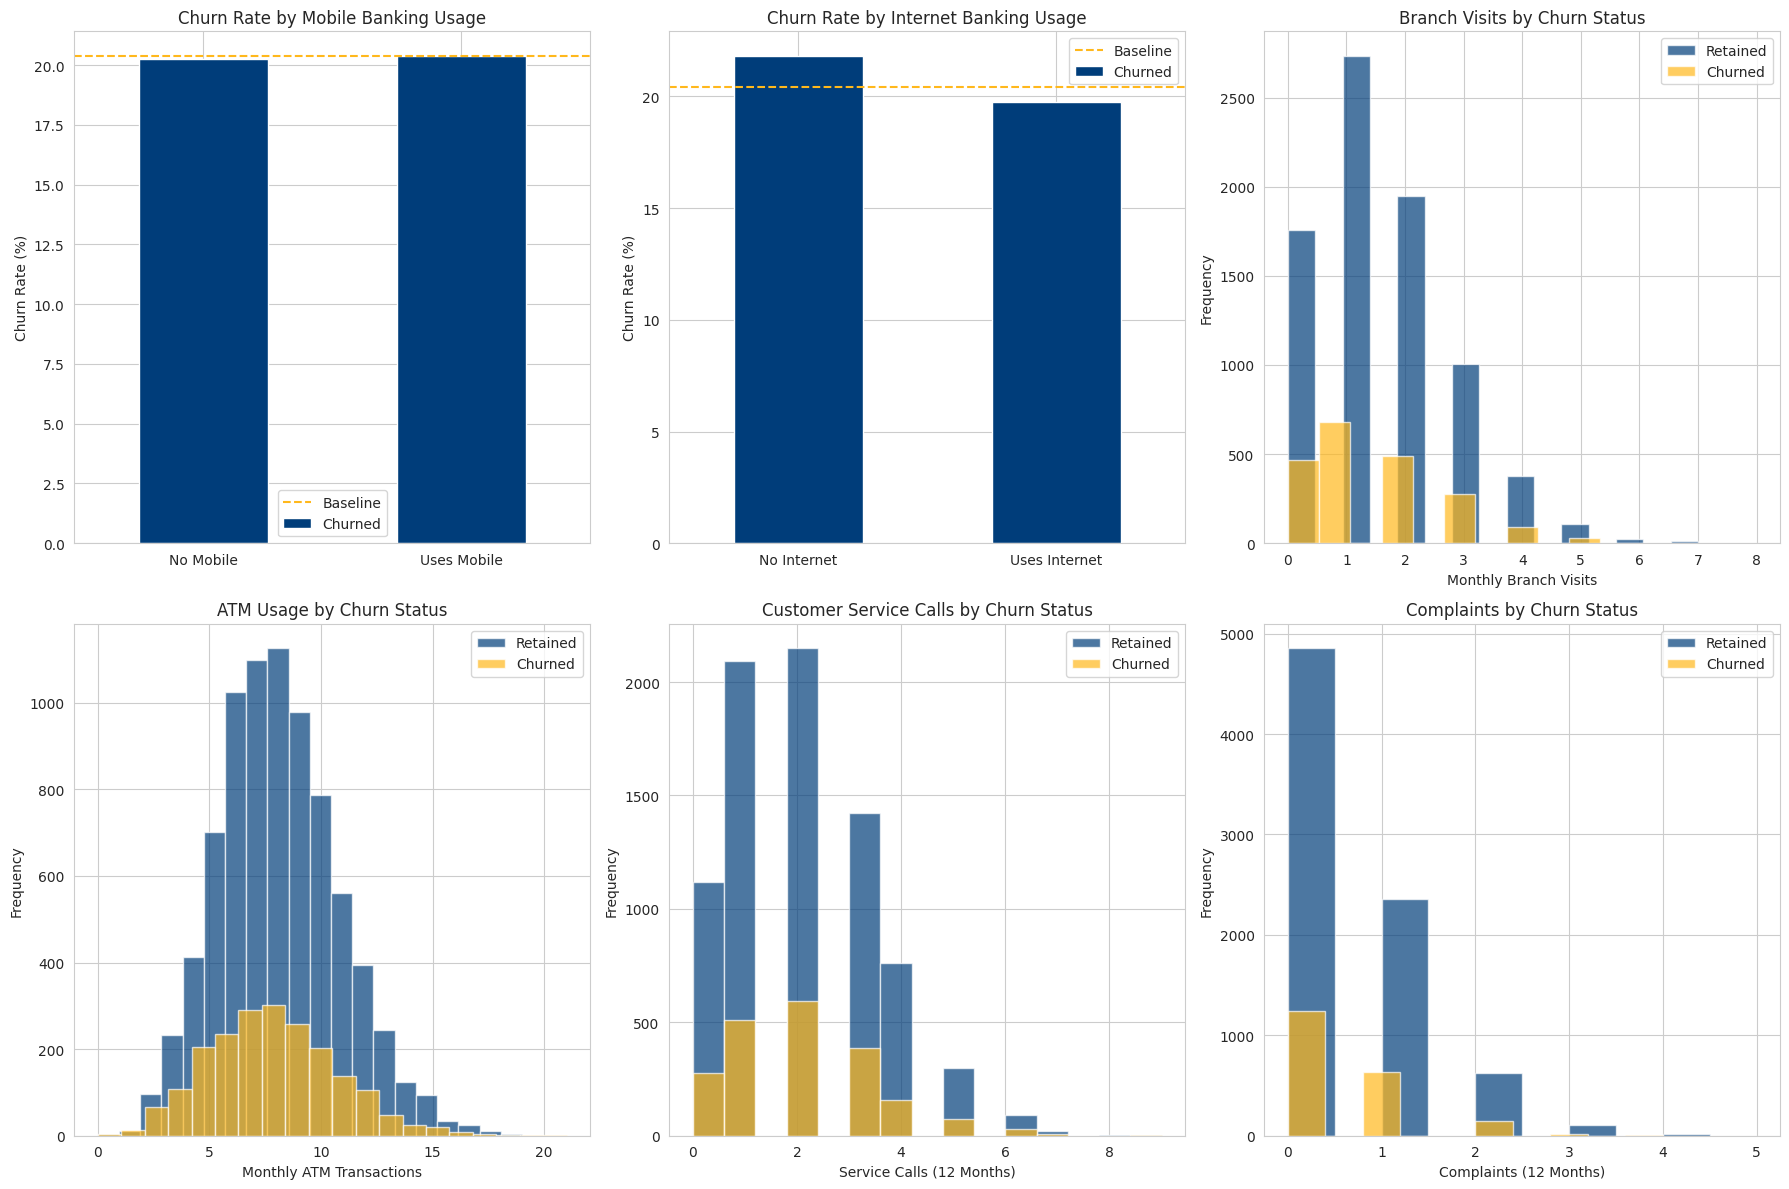

In [50]:
# Visualize digital and service patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Mobile banking adoption
mobile_churn = df.groupby("UsesMobileBanking")["Churned"].mean() * 100
mobile_churn.index = ["No Mobile", "Uses Mobile"]
mobile_churn.plot(kind="bar", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_ylabel("Churn Rate (%)")
axes[0, 0].set_title("Churn Rate by Mobile Banking Usage")
axes[0, 0].tick_params(axis="x", rotation=0)
axes[0, 0].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 0].legend()

# Internet banking adoption
internet_churn = df.groupby("UsesInternetBanking")["Churned"].mean() * 100
internet_churn.index = ["No Internet", "Uses Internet"]
internet_churn.plot(kind="bar", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_ylabel("Churn Rate (%)")
axes[0, 1].set_title("Churn Rate by Internet Banking Usage")
axes[0, 1].tick_params(axis="x", rotation=0)
axes[0, 1].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 1].legend()

# Branch visits distribution
axes[0, 2].hist(df_retained["MonthlyBranchVisits"], bins=15, alpha=0.7, label="Retained", color=fnb_blue)
axes[0, 2].hist(df_churned["MonthlyBranchVisits"], bins=15, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 2].set_xlabel("Monthly Branch Visits")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].set_title("Branch Visits by Churn Status")
axes[0, 2].legend()

# ATM transactions distribution
axes[1, 0].hist(df_retained["MonthlyATMTransactions"], bins=20, alpha=0.7, label="Retained", color=fnb_blue)
axes[1, 0].hist(df_churned["MonthlyATMTransactions"], bins=20, alpha=0.7, label="Churned", color=fnb_gold)
axes[1, 0].set_xlabel("Monthly ATM Transactions")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("ATM Usage by Churn Status")
axes[1, 0].legend()

# Service calls distribution
axes[1, 1].hist(df_retained["CustomerServiceCalls_12M"], bins=15, alpha=0.7, label="Retained", color=fnb_blue)
axes[1, 1].hist(df_churned["CustomerServiceCalls_12M"], bins=15, alpha=0.7, label="Churned", color=fnb_gold)
axes[1, 1].set_xlabel("Service Calls (12 Months)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Customer Service Calls by Churn Status")
axes[1, 1].legend()

# Complaints distribution
axes[1, 2].hist(df_retained["Complaints_12M"], bins=10, alpha=0.7, label="Retained", color=fnb_blue)
axes[1, 2].hist(df_churned["Complaints_12M"], bins=10, alpha=0.7, label="Churned", color=fnb_gold)
axes[1, 2].set_xlabel("Complaints (12 Months)")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].set_title("Complaints by Churn Status")
axes[1, 2].legend()

plt.tight_layout()
plt.savefig("eda_digital_engagement.png", dpi=150, bbox_inches="tight")
print("\nSaved: eda_digital_engagement.png")
plt.show()

## Observations

**Digital Channel Adoption**
- Mobile banking: 80.6% adoption (8,056 customers)
- Internet banking: 70.0% adoption (6,998 customers)
- High digital penetration suggests modern banking behavior, but minimal impact on churn

**Digital Channel Impact on Churn**
- Mobile banking: virtually no difference (20.4% users vs 20.3% non-users)
- Internet banking: slight protective effect (19.7% users vs 21.8% non-users, 2.1pp difference)
- Neither channel shows strong retention value
- Digital adoption does not appear to drive loyalty in this dataset

**Branch and ATM Usage**
- Nearly identical patterns between retained and churned customers
- Branch visits: 1.50 vs 1.48 monthly (negligible difference)
- ATM transactions: 8.04 vs 7.97 monthly (negligible difference)
- Both groups show similar physical channel engagement
- Distributions overlap almost completely in histograms

**Service Friction Indicators**
- Customer service calls: 2.00 vs 2.01 annually (no meaningful difference)
- Complaints: 0.50 vs 0.49 annually (no meaningful difference)
- Service call and complaint patterns do not differentiate churned from retained customers
- Most customers cluster at 0-2 service calls and 0-1 complaints

**Key Insight**

This section reveals a surprising null result. Digital adoption, physical channel usage, and service interaction patterns show minimal to no correlation with churn. The distributions are nearly identical between retained and churned groups across all metrics.

This contrasts sharply with the strong signals from:
- Age (7.4 year difference)
- Geography (2.2x provincial variation)
- Product complexity (100% churn at 4 products)
- Personal loans (85.9% churn)
- Active member status (12.6pp difference)

The lack of digital/service differentiation suggests churn drivers are primarily about product fit, customer life stage, and competitive dynamics rather than channel preferences or service friction. Customers are not leaving because of poor digital experiences or excessive service calls. They are leaving for reasons related to age, location, and product portfolio mismatch.

This finding is strategically important because it means investments in digital channel improvements alone will not address the churn problem. The root causes lie elsewhere.

## Section 13: Demographic Analysis

Examining demographic and socioeconomic factors to identify any churn patterns across gender, education, employment, and language preferences. These dimensions can reveal underserved segments or cultural factors influencing retention.

In [51]:
# Gender analysis
print("Gender Analysis:")
gender_churn = df.groupby("Gender")["Churned"].agg(["mean", "count"])
gender_churn["churn_rate_%"] = (gender_churn["mean"] * 100).round(1)
print(gender_churn[["count", "churn_rate_%"]])

Gender Analysis:
        count  churn_rate_%
Gender                     
Female   4543         25.10
Male     5457         16.50


In [52]:
# Chi-square test for gender
gender_contingency = pd.crosstab(df["Gender"], df["Churned"])
chi2, p_value, dof, expected = chi2_contingency(gender_contingency)

print(f"\nChi-square test (Gender vs Churn):")
print(f"χ²={chi2:.2f}, p={p_value:.4f}")
if p_value < 0.05:
    print("Gender and churn are statistically associated")


Chi-square test (Gender vs Churn):
χ²=112.92, p=0.0000
Gender and churn are statistically associated


In [53]:
# Education level
print("\nEducation Level:")
edu_churn = df.groupby("EducationLevel")["Churned"].agg(["mean", "count"])
edu_churn["churn_rate_%"] = (edu_churn["mean"] * 100).round(1)
edu_churn = edu_churn.sort_values("churn_rate_%", ascending=False)
print(edu_churn[["count", "churn_rate_%"]])


Education Level:
                count  churn_rate_%
EducationLevel                     
Matric           3491         20.90
Diploma          2484         20.30
Degree           1497         20.20
No Matric        1557         20.20
Postgraduate      971         18.90


In [54]:
# Employment type
print("\nEmployment Type:")
emp_churn = df.groupby("EmploymentType")["Churned"].agg(["mean", "count"])
emp_churn["churn_rate_%"] = (emp_churn["mean"] * 100).round(1)
emp_churn = emp_churn.sort_values("churn_rate_%", ascending=False)
print(emp_churn[["count", "churn_rate_%"]])


Employment Type:
                count  churn_rate_%
EmploymentType                     
Student           468         21.60
Pensioner        1010         21.20
Self-Employed    1492         21.00
Employed         5499         20.30
Unemployed       1531         19.10


In [55]:
# Preferred language (top 5)
print("\nPreferred Language (Top 5):")
lang_churn = df.groupby("PreferredLanguage")["Churned"].agg(["mean", "count"])
lang_churn["churn_rate_%"] = (lang_churn["mean"] * 100).round(1)
lang_churn = lang_churn.sort_values("count", ascending=False).head(5)
print(lang_churn[["count", "churn_rate_%"]])


Preferred Language (Top 5):
                   count  churn_rate_%
PreferredLanguage                     
English             2511         19.90
Afrikaans           1970         21.70
isiZulu             1565         21.20
isiXhosa             982         18.20
Sesotho              808         19.10


In [56]:
# Preferred communication channel
print("\nPreferred Communication Channel:")
comm_churn = df.groupby("PreferredCommChannel")["Churned"].agg(["mean", "count"])
comm_churn["churn_rate_%"] = (comm_churn["mean"] * 100).round(1)
comm_churn = comm_churn.sort_values("churn_rate_%", ascending=False)
print(comm_churn[["count", "churn_rate_%"]])


Preferred Communication Channel:
                      count  churn_rate_%
PreferredCommChannel                     
Phone Call             1035         21.70
Email                  2433         20.90
WhatsApp               2530         20.80
App Notification        999         19.90
SMS                    3003         19.20



Saved: eda_demographics.png


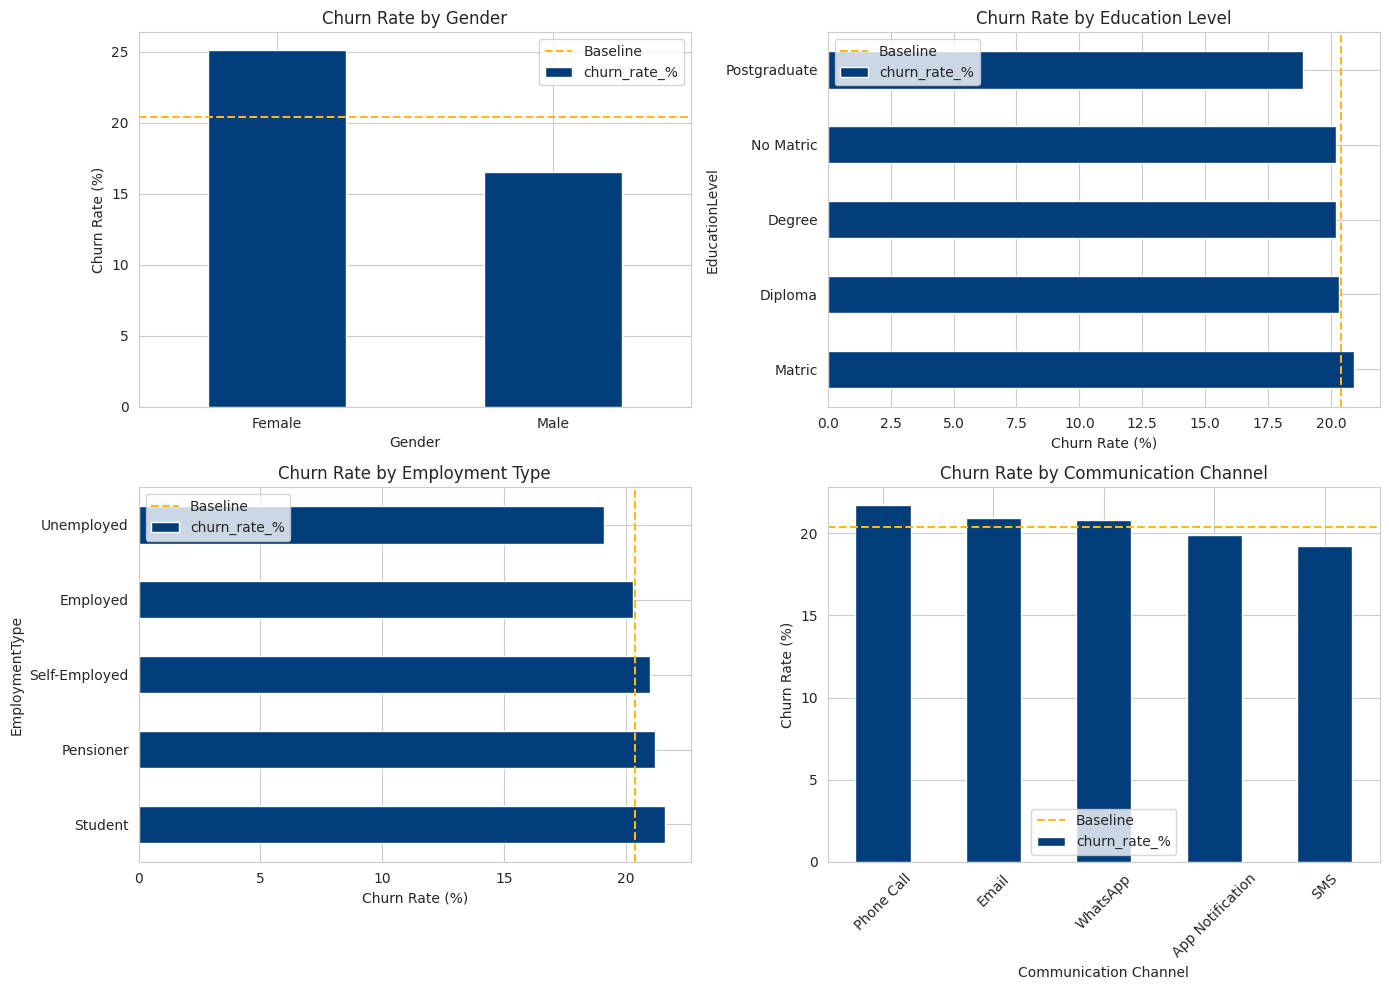

In [57]:
# Visualize demographic patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gender
gender_churn["churn_rate_%"].plot(kind="bar", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_ylabel("Churn Rate (%)")
axes[0, 0].set_title("Churn Rate by Gender")
axes[0, 0].tick_params(axis="x", rotation=0)
axes[0, 0].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 0].legend()

# Education level
edu_churn["churn_rate_%"].plot(kind="barh", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_xlabel("Churn Rate (%)")
axes[0, 1].set_title("Churn Rate by Education Level")
axes[0, 1].axvline(x=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 1].legend()

# Employment type
emp_churn["churn_rate_%"].plot(kind="barh", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_xlabel("Churn Rate (%)")
axes[1, 0].set_title("Churn Rate by Employment Type")
axes[1, 0].axvline(x=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[1, 0].legend()

# Communication channel
comm_churn["churn_rate_%"].plot(kind="bar", ax=axes[1, 1], color=fnb_blue)
axes[1, 1].set_xlabel("Communication Channel")
axes[1, 1].set_ylabel("Churn Rate (%)")
axes[1, 1].set_title("Churn Rate by Communication Channel")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("eda_demographics.png", dpi=150, bbox_inches="tight")
print("\nSaved: eda_demographics.png")
plt.show()

## Observations

**Gender Disparity (Significant Finding)**
- Female customers: 25.1% churn (4,543 customers)
- Male customers: 16.5% churn (5,457 customers)
- 8.6pp difference, statistically significant (χ²=112.92, p<0.0001)
- This represents a 52% relative increase in churn for female customers
- Warrants investigation into whether product offerings, service quality, or competitive dynamics differentially impact female customers

**Education Level**
- Narrow range: 18.9% to 20.9% churn
- Postgraduate: 18.9% (lowest, but marginal)
- Matric: 20.9% (highest, but marginal)
- Education does not appear to drive churn meaningfully
- All segments cluster around the 20.4% baseline

**Employment Type**
- Similar pattern: 19.1% to 21.6% range
- Student: 21.6% (slightly elevated, small sample of 468)
- Unemployed: 19.1% (lowest, counterintuitively)
- Employed: 20.3% (largest segment at 5,499 customers, near baseline)
- Employment status is not a strong churn predictor

**Preferred Language**
- Top 5 languages show 18.2% to 21.7% range
- Afrikaans: 21.7% (highest)
- isiXhosa: 18.2% (lowest)
- English: 19.9% (largest segment at 2,511 customers)
- Differences are small and likely not actionable
- Language preference does not meaningfully segment churn risk

**Communication Channel Preference**
- Even narrower range: 19.2% to 21.7%
- Phone call: 21.7%
- SMS: 19.2%
- All channels cluster around baseline
- Channel preference is not a churn driver

**Key Insight**

The gender gap is the only meaningful demographic finding. An 8.6pp difference (25.1% vs 16.5%) with strong statistical significance suggests systematic differences in how male and female customers experience FNB or evaluate alternatives.

Possible explanations worth investigating:
- Product offerings may not align with female customer needs
- Service quality perceptions may differ by gender
- Competitive offerings may be more attractive to female customers
- Marketing and retention strategies may be inadvertently optimized for male customers

In contrast, education, employment, language, and communication channel show minimal variation. These demographics do not segment churn risk effectively and should not be primary targeting variables for retention programs.

The gender finding adds another dimension to the churn profile:
- Age: 46-55 cohort (50.6% churn)
- Geography: Limpopo/Eastern Cape/Mpumalanga (32-34% churn)
- Gender: Female (25.1% churn)
- Products: Personal loans (85.9% churn), 3-4 products (83-100% churn)

These are the actionable segmentation variables. The rest (education, employment, language, channels) are noise.

## Section 14: Correlation Analysis

Examining linear relationships between numerical features and churn to identify which variables have the strongest associations. This helps prioritize features for predictive modeling and validates findings from categorical analysis.

In [58]:
# Select numerical features (exclude identifiers)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["RowNumber", "CustomerId"]]

print(f"Analyzing correlations for {len(numerical_cols)} numerical features")

Analyzing correlations for 25 numerical features


In [59]:
# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Rank features by correlation with churn
churn_corr = corr_matrix["Churned"].sort_values(ascending=False)

print("\nTop 15 Features Correlated with Churn:")
print(churn_corr.head(16).round(3))


Top 15 Features Correlated with Churn:
Churned                     1.00
HasPersonalLoan             0.30
Age                         0.28
HasPremiumBanking           0.15
Balance_ZAR                 0.12
FinancialWellnessScore      0.07
AnnualSalary_ZAR            0.01
MonthlySalary_ZAR           0.01
HasInvestmentAccount        0.01
CustomerServiceCalls_12M    0.00
UsesMobileBanking           0.00
HasHomeLoan                -0.00
HasVehicleFinance          -0.00
MonthlyBranchVisits        -0.01
HasCreditCard_Flag         -0.01
Complaints_12M             -0.01
Name: Churned, dtype: float64



Saved: eda_correlation_matrix.png


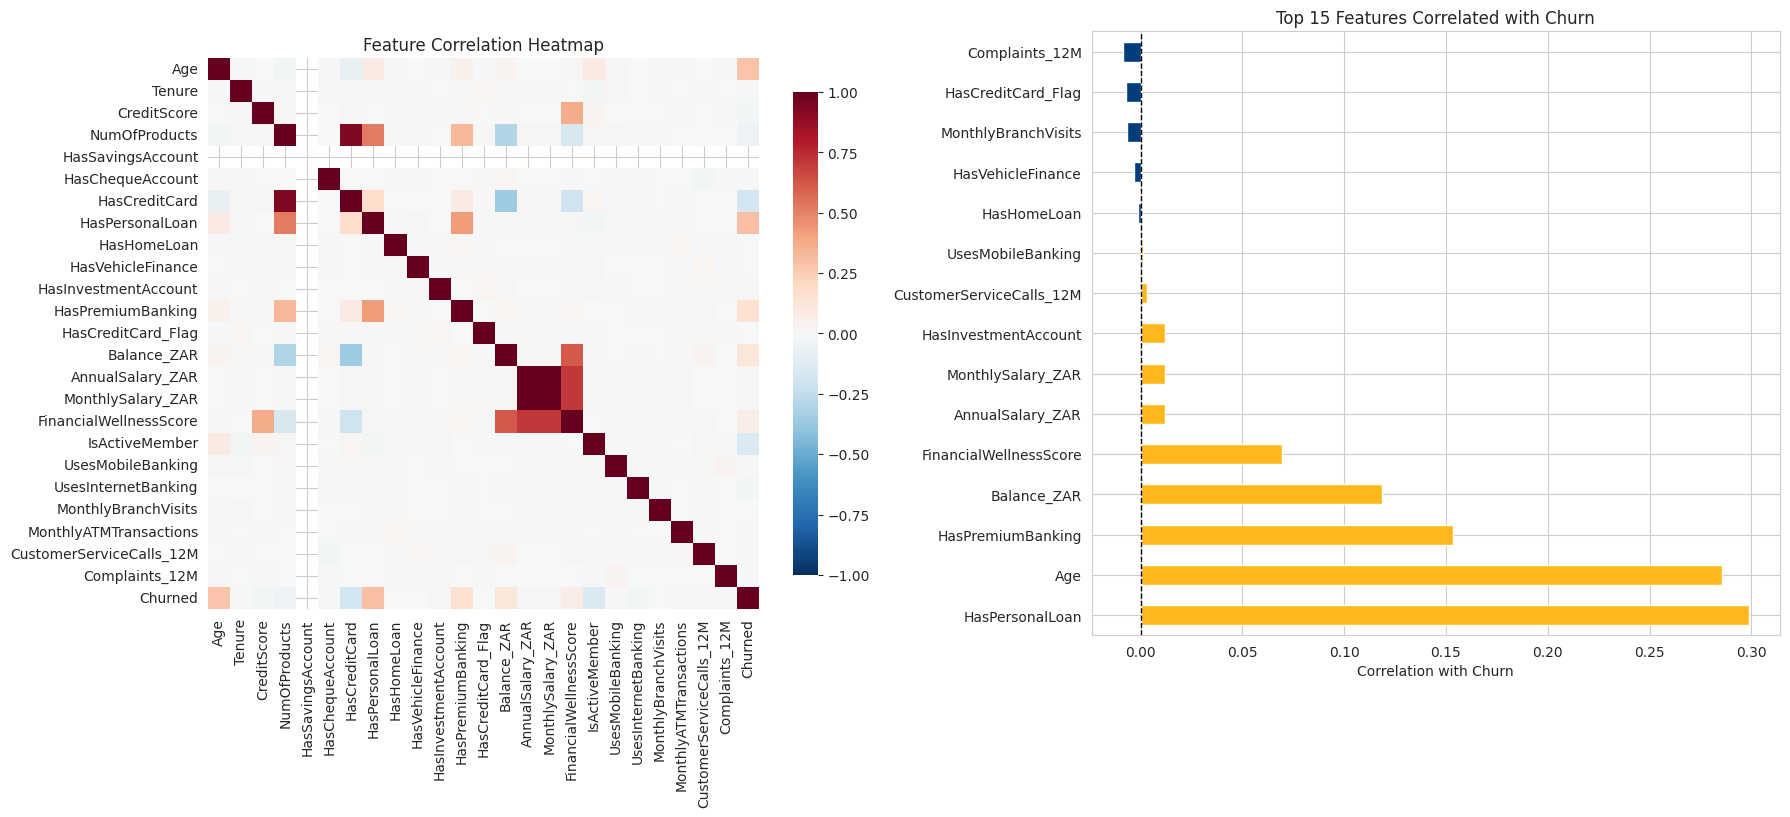

In [60]:
# Visualize correlation patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Correlation heatmap
sns.heatmap(
    corr_matrix,
    cmap="RdBu_r",
    center=0,
    square=True,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns,
    cbar_kws={"shrink": 0.8},
    ax=axes[0],
    vmin=-1,
    vmax=1
)
axes[0].set_title("Feature Correlation Heatmap")
axes[0].tick_params(axis="x", rotation=90)
axes[0].tick_params(axis="y", rotation=0)

# Top correlations with churn
churn_corr_plot = churn_corr.drop("Churned").head(15)
colors = [fnb_gold if x > 0 else fnb_blue for x in churn_corr_plot]
churn_corr_plot.plot(kind="barh", ax=axes[1], color=colors)
axes[1].set_xlabel("Correlation with Churn")
axes[1].set_title("Top 15 Features Correlated with Churn")
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("eda_correlation_matrix.png", dpi=150, bbox_inches="tight")
print("\nSaved: eda_correlation_matrix.png")
plt.show()

## Observations

**Strongest Positive Correlations (Churn Drivers)**
- HasPersonalLoan: 0.30 (by far the strongest correlation)
- Age: 0.28 (second strongest)
- HasPremiumBanking: 0.15 (moderate)
- Balance_ZAR: 0.12 (weak but positive)
- FinancialWellnessScore: 0.07 (very weak)

**Weak or Near-Zero Correlations**
- Salary metrics (Annual, Monthly): 0.01 (essentially no relationship)
- Service interactions (calls, complaints, branch visits): 0.00 to -0.01 (no relationship)
- Digital banking usage: 0.00 (no relationship)
- Most product flags: near zero except personal loans

**Key Insights from Correlation Patterns**

The correlation analysis confirms and quantifies earlier findings:

1. **Personal loans are the dominant product risk factor** (r=0.30). This is 7x stronger than the next product correlation and aligns with the 85.9% churn rate observed for personal loan holders.

2. **Age is the strongest demographic predictor** (r=0.28). This validates the 7.4-year age difference and 50.6% churn in the 46-55 cohort.

3. **Financial metrics show weak correlations**. Balance (0.12), salary (0.01), and financial wellness (0.07) barely predict churn. This contradicts typical banking assumptions that low-value customers churn more. The positive balance correlation reinforces that higher-value customers are leaving.

4. **Service and engagement metrics are uncorrelated with churn**. Service calls (0.00), complaints (-0.01), branch visits (-0.01), and digital banking (0.00) show no relationship. This confirms the null finding from the digital banking analysis.

5. **Premium banking shows moderate positive correlation** (r=0.15). This aligns with the VIP segment's 35% churn rate, indicating failures at the high-end service tier.

**Correlation Heatmap Patterns**

- Strong diagonal (1.0 correlations with self)
- Salary variables highly correlated with each other (expected)
- Product ownership flags show weak intercorrelations (products are relatively independent)
- No major multicollinearity concerns for modeling
- Most features weakly correlated with churn (challenging for linear models)

**Modeling Implications**

The weak overall correlations (highest at 0.30) suggest:
- Linear models may struggle with this dataset
- Non-linear methods (tree-based models) likely needed to capture interactions
- Feature engineering will be critical (age groups, product complexity scores, geographic flags)
- Age and personal loans are must-include features
- Many features can potentially be dropped (service metrics, salary, digital flags)

The correlation analysis provides a quantitative foundation for the patterns observed in categorical analysis. Age and personal loans emerge as the two strongest individual predictors, while service quality and digital engagement appear irrelevant to churn behavior in this dataset.

## Section 15: Executive Summary

Consolidating the key findings from exploratory analysis into a concise summary that highlights the strongest churn signals and their business implications.

In [61]:
# Dataset overview
total_customers = len(df)
churn_rate = df["Churned"].mean()
churned_count = df_churned.shape[0]
retained_count = df_retained.shape[0]

print("=" * 80)
print("EXECUTIVE SUMMARY: FNB CUSTOMER CHURN ANALYSIS")
print("=" * 80)

print("\nDataset Overview:")
print(f"Total customers: {total_customers:,}")
print(f"Churned: {churned_count:,} ({churn_rate:.1%})")
print(f"Retained: {retained_count:,} ({(1 - churn_rate):.1%})")

EXECUTIVE SUMMARY: FNB CUSTOMER CHURN ANALYSIS

Dataset Overview:
Total customers: 10,000
Churned: 2,037 (20.4%)
Retained: 7,963 (79.6%)


In [62]:
print("\nKey Findings:")

# Age insight
age_diff = df_churned["Age"].mean() - df_retained["Age"].mean()
age_46_55_churn = df[df["AgeGroup"] == "46-55"]["Churned"].mean() * 100
print("\n1. Age (Strongest Demographic Driver)")
print(f"   - Churned customers are {age_diff:.1f} years older on average")
print(f"   - 46-55 age cohort: {age_46_55_churn:.1f}% churn rate (2.5x baseline)")
print(f"   - Statistical significance: t=29.77, p<0.0001")

# Geographic insight
province_churn = df.groupby("Province")["Churned"].mean() * 100
highest_churn_province = province_churn.idxmax()
lowest_churn_province = province_churn.idxmin()
print("\n2. Geography (Regional Concentration)")
print(f"   - Highest churn: {highest_churn_province} ({province_churn[highest_churn_province]:.1f}%)")
print(f"   - Lowest churn: {lowest_churn_province} ({province_churn[lowest_churn_province]:.1f}%)")
print(f"   - Top 3 provinces (Limpopo, Eastern Cape, Mpumalanga): 2x baseline")
print(f"   - Counter-intuitive: high-churn provinces have higher average balances")

# Product insight
product_churn = df.groupby("NumOfProducts")["Churned"].mean() * 100
personal_loan_churn = df[df["HasPersonalLoan"] == 1]["Churned"].mean() * 100
print("\n3. Product Complexity (Critical Finding)")
print(f"   - 1 product: {product_churn[1]:.1f}% churn (under-engaged)")
print(f"   - 2 products: {product_churn[2]:.1f}% churn (optimal)")
print(f"   - 3 products: {product_churn[3]:.1f}% churn (over-banked)")
print(f"   - 4 products: {product_churn[4]:.1f}% churn (complete failure)")
print(f"   - Personal loan holders: {personal_loan_churn:.1f}% churn (CRISIS)")

# Financial insight
balance_diff = df_churned["Balance_ZAR"].mean() - df_retained["Balance_ZAR"].mean()
zero_balance_churn = df[df["Balance_ZAR"] == 0]["Churned"].mean() * 100
print("\n4. Financial Profile (Counter-Intuitive)")
print(f"   - Churned customers have R{balance_diff:,.0f} higher average balance")
print(f"   - Zero-balance customers: {zero_balance_churn:.1f}% churn (lower than baseline)")
print(f"   - Conclusion: losing valuable customers, not trimming low-value accounts")

# Credit insight
credit_diff = df_churned["CreditScore"].mean() - df_retained["CreditScore"].mean()
credit_rating_churn = df.groupby("CreditRating")["Churned"].mean() * 100
print("\n5. Credit Risk (Not a Driver)")
print(f"   - Churned customers: {abs(credit_diff):.0f} points lower credit score (minimal)")
print(f"   - Credit rating churn range: {credit_rating_churn.min():.1f}% to {credit_rating_churn.max():.1f}%")
print(f"   - Conclusion: churn is not about credit risk")

# Engagement insight
active_churn = df[df["IsActiveMember"] == 1]["Churned"].mean() * 100
inactive_churn = df[df["IsActiveMember"] == 0]["Churned"].mean() * 100
print("\n6. Engagement (Moderate Impact)")
print(f"   - Active members: {active_churn:.1f}% churn")
print(f"   - Inactive members: {inactive_churn:.1f}% churn")
print(f"   - Difference: {inactive_churn - active_churn:.1f}pp")

# Gender insight
female_churn = df[df["Gender"] == "Female"]["Churned"].mean() * 100
male_churn = df[df["Gender"] == "Male"]["Churned"].mean() * 100
print("\n7. Gender Gap (Significant Disparity)")
print(f"   - Female customers: {female_churn:.1f}% churn")
print(f"   - Male customers: {male_churn:.1f}% churn")
print(f"   - Difference: {female_churn - male_churn:.1f}pp (χ²=112.92, p<0.0001)")

# Digital banking insight
mobile_users_churn = df[df["UsesMobileBanking"] == 1]["Churned"].mean() * 100
mobile_non_users_churn = df[df["UsesMobileBanking"] == 0]["Churned"].mean() * 100
print("\n8. Digital Banking & Service (Null Finding)")
print(f"   - Mobile banking users: {mobile_users_churn:.1f}% churn")
print(f"   - Non-users: {mobile_non_users_churn:.1f}% churn")
print(f"   - Service calls, complaints, branch visits: no correlation with churn")
print(f"   - Conclusion: churn not driven by digital/service quality")

print("\n" + "=" * 80)


Key Findings:

1. Age (Strongest Demographic Driver)
   - Churned customers are 7.4 years older on average
   - 46-55 age cohort: 50.6% churn rate (2.5x baseline)
   - Statistical significance: t=29.77, p<0.0001

2. Geography (Regional Concentration)
   - Highest churn: Limpopo (33.9%)
   - Lowest churn: KwaZulu-Natal (15.3%)
   - Top 3 provinces (Limpopo, Eastern Cape, Mpumalanga): 2x baseline
   - Counter-intuitive: high-churn provinces have higher average balances

3. Product Complexity (Critical Finding)
   - 1 product: 27.7% churn (under-engaged)
   - 2 products: 7.6% churn (optimal)
   - 3 products: 82.7% churn (over-banked)
   - 4 products: 100.0% churn (complete failure)
   - Personal loan holders: 85.9% churn (CRISIS)

4. Financial Profile (Counter-Intuitive)
   - Churned customers have R376,446 higher average balance
   - Zero-balance customers: 13.8% churn (lower than baseline)
   - Conclusion: losing valuable customers, not trimming low-value accounts

5. Credit Risk (Not 

In [63]:
print("\nStrategic Implications:")
print("\nPrimary Churn Drivers (Actionable):")
print("  1. Age 46-55 cohort (50.6% churn, 1,311 customers)")
print("  2. Personal loan product (85.9% churn, 326 customers)")
print("  3. 3-4 product customers (83-100% churn, 326 customers)")
print("  4. Limpopo/Eastern Cape/Mpumalanga (32-34% churn, 2,509 customers)")
print("  5. Female customers (25.1% vs 16.5% male)")
print("  6. Inactive members (26.9% vs 14.3% active)")

print("\nNon-Drivers (Deprioritize):")
print("  - Credit score/rating")
print("  - Education level")
print("  - Employment type")
print("  - Digital banking adoption")
print("  - Service interaction frequency")
print("  - Tenure")

print("\nRecommended Focus Areas:")
print("  1. Immediate personal loan product review")
print("  2. Age-targeted retention for 45-55 cohort")
print("  3. Geographic interventions in top-3 provinces")
print("  4. Product simplification (avoid 3+ product cross-sell)")
print("  5. Gender-specific retention analysis")
print("  6. Inactive member reactivation campaigns")

print("\n" + "=" * 80)


Strategic Implications:

Primary Churn Drivers (Actionable):
  1. Age 46-55 cohort (50.6% churn, 1,311 customers)
  2. Personal loan product (85.9% churn, 326 customers)
  3. 3-4 product customers (83-100% churn, 326 customers)
  4. Limpopo/Eastern Cape/Mpumalanga (32-34% churn, 2,509 customers)
  5. Female customers (25.1% vs 16.5% male)
  6. Inactive members (26.9% vs 14.3% active)

Non-Drivers (Deprioritize):
  - Credit score/rating
  - Education level
  - Employment type
  - Digital banking adoption
  - Service interaction frequency
  - Tenure

Recommended Focus Areas:
  1. Immediate personal loan product review
  2. Age-targeted retention for 45-55 cohort
  3. Geographic interventions in top-3 provinces
  4. Product simplification (avoid 3+ product cross-sell)
  5. Gender-specific retention analysis
  6. Inactive member reactivation campaigns

